# CLASSIFICATION OF DISTRACTOR IDENTITY IN A VISUAL SEARCH TASK 

In [1]:
import datetime
print(datetime.date.today())

2023-09-22


In [341]:
#import modules

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
rs = 666  # random state
random.seed(rs)  

import pickle as pk

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten

import shap 
shap.initjs()

import warnings
warnings.filterwarnings("ignore")

In [3]:
# import raw data
datafile = r'./alldata.csv'

df_raw = pd.read_csv(datafile)

# Data cleaning

In [4]:
df = df_raw[df_raw.phase == 2]  # only testing phase for this analysis
df = df[df.practice == 0]  # no familiarisation trials 
df = df[df.response != 0]  # only trials with response given 
print('raw dataset shape:', df.shape)

raw dataset shape: (13666, 138)


In [5]:
df.describe()

,Unnamed: 0.3,Unnamed: 0,subject,age,studies,gender,group,session,target_id,target_position,target_color,target_line,dist_id,dist_position,dist_color,dist_presence,dist_line,time_presentation,time_end,color1,color2,color3,color4,color5,color6,response,correctness,reaction_time,practice,block,trial,phase,date,condition,position1,position2,position3,position4,position5,position6,outlier_cpt,selec_hist,subject.2,target_id.1,target_position.1,dist_id.1,response.1,reaction_time.1,trial.2,phase.1,practice.1,condition.1,dist_presence.1,len,out,subject.1,trial.1,code,nb_sac,nb_sac_before_resp,amplitude_1,latency_1,duration_1,end_x1,end_y1,amplitude_2,latency_2,duration_2,end_x2,end_y2,ampli_targ,lat_targ,ampli_dist,lat_dist,desti_sac1,target_pos,dist_type,dist_pos,th_sacc_target,th_sacc_dist,correctness.1,eyeOK,toprev_target,Unnamed: 0.1,Unnamed: 0.2,subject.3,target_id.2,target_position.2,dist_id.2,response.2,reaction_time.2,trial.3,condition.2,dist_presence.2,len.1,out.1,subj,epoch,code.1,peak_amplitude,peak_latency,response_latency,onset12_latency,offset12_latency,burst12_duration,burst12_surface,burst12_avg,slope12,mt_12,onset_latency,offset_latency,burst_duration,burst_surface,burst_avg,slope,mt,burst12_sum,12topeak_sum,12toresp_sum,burst_sum,topeak_sum,toresp_sum,ct12,ct,avg_ic,avg_cc,surface_ic,surface_cc,ic_latency,cc_latency,line_ori,dist_type.1,correct_resp,given_resp,partial_resp,correctness.2,out_emg,subject_out_emg_ampli
count,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.0,13666.000000,13666.000000,13666.0,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,1.366600e+04,1.366600e+04,13666.0,13666.0,13666.0,13666.0,13666.0,13666.000000,13666.000000,13666.000000,13666.000000,13666.0,13666.000000,13666.000000,13666.0,1.366600e+04,13666.000000,13205.000000,13205.000000,13205.000000,13205.000000,13205.000000,13205.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.0,13666.0,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,1.366600e+04,13340.000000,11699.000000,11310.000000,11310.000000,11310.000000,11310.000000,11310.000000,7495.000000,7495.000000,7495.000000,7495.000000,7495.000000,10894.000000,10894.000000,1814.000000,1814.000000,11310.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,1.340500e+04,13405.000000,13405.000000,13405.000000,13405.000000,13405.000000,13405.000000,1.340500e+04,13405.000000,13405.000000,13405.000000,13405.000000,13405.000000,1.340500e+04,1.340500e+04,13405.000000,13405.000000,1.340500e+04,1.340500e+04,13405.000000,1.340500e+04,13405.000000,13405.000000,3308.000000,3308.000000,2.007000e+03,1301.000000,2.007000e+03,1.301000e+03,2007.000000,1301.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000,13666.000000
mean,13600.799210,822.259769,12.409410,25.755305,5.492536,1.377945,2.521806,1.0,1.504171,3.493414,0.0,1.499488,1.193253,3.499780,1.195302,0.595346,3.403556,2.789063e+05,2.789070e+05,0.0,0.0,0.0,0.0,0.0,1.195302,3.496854,0.933850,698.924502,0.0,5.545514,30.528904,2.0,2.022092e+07,16.192522,3.494055,1.402651,2.801969,4.201363,5.600454,3.499508,0.017050,0.395434,12.409410,1.504171,3.493414,1.193253,3.496854,698.924502,30.528904,2.0,0.0,16.192522,0.595346,1.496780,0.017635,12.409410,823.259769,3.635043e+06,2.086432,1.933328,2.161263,218.400796,39.443590,-0.095202,-0.013343,2.602174,374.762909,38.566111,-0.113219,-0.039437,2.629777,352.385625,2.350255,244.670893,3.677100,3.493414,1.193253,2.084663,1.428362,0.169033,1.066150,0.976145,0.208913,7147.905898,7147.905898,12.409410,1.504171,3.493414,1.193253,3.496854,

Some variables does not mean anything (resulting from previous data manipulations) and some others are totally useless for the current problem. We remove these variables based on prior knowledge of the experiment and dataset. 

In [6]:
var = df.columns

del_col = []

for v in var:
    # suppress columns called 'unnamed...' because it results from concatenation of previous tables
    if v.startswith('Unnamed'):
        del_col.append(v)
    # suppress personal data about participants because not informative about the trial type
    elif v.startswith('age'):
        del_col.append(v)
    elif v.startswith('subject'):
        del_col.append(v)
    elif v.startswith('stud'):
        del_col.append(v)
    elif v.startswith('gend'):
        del_col.append(v)
    elif v.startswith('group'):
        del_col.append(v)
    elif v.startswith('date'):
        del_col.append(v)
    # suppress data about the trial because we want to classify based on participant's data only
    elif v.startswith('session'):
        del_col.append(v)
    elif v.startswith('target'):
        del_col.append(v)
    elif v.startswith('dist') and v != 'dist_id':
        del_col.append(v)
    elif v.startswith('pos'):
        del_col.append(v)
    elif v.startswith('colo'):
        del_col.append(v)
    elif v.startswith('pract'):
        del_col.append(v)
    elif v.startswith('block'):
        del_col.append(v)
    elif v.startswith('trial'):
        del_col.append(v)
    elif v.startswith('phase'):
        del_col.append(v)
    elif v.startswith('condition'):
        del_col.append(v)
    elif v.startswith('time_'):
        del_col.append(v)
    elif v.startswith('correct_'):
        del_col.append(v)
    elif v.startswith('out'):
        del_col.append(v)
    elif v.startswith('len'):
        del_col.append(v)
    elif v.startswith('code'):
        del_col.append(v)
    elif v.startswith('eyeOK'):
        del_col.append(v)
    elif v.startswith('epoch'):
        del_col.append(v)
    elif v.startswith('line'):
        del_col.append(v)
    elif v.startswith('given'):
        del_col.append(v)
    elif 'response' in v:
        del_col.append(v)
    elif v.startswith('selec'):
        del_col.append(v)
    elif v.startswith('end_'):
        del_col.append(v)
    # remove double variables
    if '.' in v:
        del_col.append(v)
    if (v == 'desti_sac1') | (v == 'toprev_target') | (v == 'rejection_emg'):
        del_col.append(v)
    # for emg data, we used 2 separate methods to detect the burst, measures are very close so we will only use one for classification (remove the 1/2 hauteur method here)
    if '12' in v:
        del_col.append(v)
    # we remove data that was calculated with prior knowledge of the distractor category
    if (v == 'ampli_dist') | (v == 'th_sacc_dist') | (v == 'lat_dist'):
        del_col.append(v)
    
df.drop(del_col, axis=1, inplace=True)

print('dataset shape after columns removal:', df.shape)
print('actual columns:', df.columns)

dataset shape after columns removal: (13666, 35)
actual columns: Index(['dist_id', 'correctness', 'reaction_time', 'nb_sac',
       'nb_sac_before_resp', 'amplitude_1', 'latency_1', 'duration_1',
       'amplitude_2', 'latency_2', 'duration_2', 'ampli_targ', 'lat_targ',
       'th_sacc_target', 'subj', 'peak_amplitude', 'peak_latency',
       'onset_latency', 'offset_latency', 'burst_duration', 'burst_surface',
       'burst_avg', 'slope', 'mt', 'burst_sum', 'topeak_sum', 'toresp_sum',
       'ct', 'avg_ic', 'avg_cc', 'surface_ic', 'surface_cc', 'ic_latency',
       'cc_latency', 'partial_resp'],
      dtype='object')


The variable 'partial_resp' corresponds to the presence of specific events in the trial EMG (0 for noise, 1 for partial error, 2 for partial correct, 3 for nothing). Other variables will exist only if 'partial_resp' is 1 or 2. 
When partial resp is 0, we should not take into account the EMG data (but still we can use other variables)... How to deal with that ? 

**First recode it to get different variables.**
We create 2 new binary variables giving indivations about the presence or absence of a partial error or a partial correct response in the trial. 

In [7]:
# Encode partial_resp variable
partial_error = []
partial_correct = []
rejection_emg = []
for row in range(df.shape[0]):
    if df.partial_resp.iloc[row] == 0:
        partial_error.append(0)
        partial_correct.append(0)
        rejection_emg.append(1)
    elif df.partial_resp.iloc[row] == 1: 
        partial_error.append(1)
        partial_correct.append(0)
        rejection_emg.append(0)
    elif df.partial_resp.iloc[row] == 2: 
        partial_error.append(0)
        partial_correct.append(1)
        rejection_emg.append(0)
    else:
        partial_error.append(0)
        partial_correct.append(0)
        rejection_emg.append(0)

df['partial_error'] = partial_error
df['partial_correct'] = partial_correct
df.drop('partial_resp', axis=1, inplace=True)

In [8]:
df.describe()

,dist_id,correctness,reaction_time,nb_sac,nb_sac_before_resp,amplitude_1,latency_1,duration_1,amplitude_2,latency_2,duration_2,ampli_targ,lat_targ,th_sacc_target,subj,peak_amplitude,peak_latency,onset_latency,offset_latency,burst_duration,burst_surface,burst_avg,slope,mt,burst_sum,topeak_sum,toresp_sum,ct,avg_ic,avg_cc,surface_ic,surface_cc,ic_latency,cc_latency,partial_error,partial_correct
count,13666.000000,13666.000000,13666.000000,13340.000000,11699.000000,11310.000000,11310.000000,11310.000000,7495.000000,7495.000000,7495.000000,10894.000000,10894.000000,13666.000000,13666.000000,1.340500e+04,13405.000000,13405.000000,13405.000000,13405.000000,1.340500e+04,1.340500e+04,13405.000000,13405.000000,1.340500e+04,13405.000000,13405.000000,3308.000000,2.007000e+03,1301.000000,2.007000e+03,1.301000e+03,2007.000000,1301.000000,13666.000000,13666.000000
mean,1.193253,0.933850,698.924502,2.086432,1.933328,2.161263,218.400796,39.443590,2.602174,374.762909,38.566111,2.629777,352.385625,1.428362,12.409410,1.682253e-03,0.710721,0.612451,0.877146,0.264695,8.079284e-05,2.778855e-04,0.000075,0.087171,8.085857e-02,0.028943,0.022759,0.172436,1.300822e-05,0.000049,5.614504e-07,2.230550e-06,0.491823,0.533862,0.146861,0.095200
std,1.168391,0.248552,175.574746,1.273445,0.979705,0.852009,85.420867,13.603279,1.621272,112.251742,15.400286,1.398179,125.952531,0.953602,6.843814,3.569188e-03,0.189884,0.172063,0.221418,0.140238,1.651804e-04,4.668993e-04,0.000226,0.033491,1.652435e-01,0.063904,0.035397,0.107621,1.535923e-05,0.000052,1.060298e-06,5.787672e-06,0.163418,0.198523,0.353980,0.293501
min,0.000000,0.000000,4.167400,0.000000,0.000000,0.150087,2.000000,6.000000,0.153412,30.000000,6.000000,0.153089,2.000000,0.000000,1.000000,6.508682e-15,-0.105000,-0.141000,-0.104000,0.029000,1.434096e-16,3.979996e-15,-0.000056,-0.054000,1.493666e-13,0.000000,0.000000,0.016000,8.171231e-07,0.000005,8.585433e-09,3.399578e-08,0.130000,0.086000,0.000000,0.000000
25%,0.000000,1.000000,569.072675,1.000000,1.000000,1.699024,177.000000,31.000000,1.197252,300.000000,27.000000,1.754620,259.000000,1.000000,7.000000,5.204501e-04,0.569000,0.486000,0.710000,0.152000,1.878770e-05,9.347030e-05,0.000023,0.067000,1.882240e-02,0.006412,0.008128,0.094000,5.898689e-06,0.000022,1.571942e-07,5.111748e-07,0.377000,0.386000,0.000000,0.000000
50%,1.000000,1.000000,670.809900,2.000000,2.000000,2.319827,222.000000,39.000000,2.482243,360.000000,38.000000,2.599062,331.000000,2.000000,12.000000,9.655004e-04,0.681000,0.585000,0.854000,0.214000,3.807633e-05,1.674663e-04,0.000047,0.082000,3.813123e-02,0.013701,0.015644,0.150000,9.025553e-06,0.000036,2.813981e-07,9.428481e-07,0.468000,0.510000,0.000000,0.000000
75%,2.000000,1.000000,802.973375,3.000000,3.000000,2.752730,258.000000,48.000000,3.695144,431.000000,50.000000,3.243373,421.000000,2.000000,18.000000,1.622538e-03,0.827000,0.715000,1.017000,0.371000,7.262467e-05,2.747044e-04,0.000090,0.100000,7.267156e-02,0.027499,0.026435,0.220000,1.412527e-05,0.000060,5.393402e-07,2.028028e-06,0.588000,0.664000,0.000000,0.000000
max,3.000000,1.000000,1200.143900,8.000000,7.000000,7.206710,1115.000000,124.000000,8.583897,1000.000000,130.000000,8.583897,1115.000000,6.000000,24.000000,6.429350e-02,1.616000,1.147000,1.799000,1.366000,2.697597e-03,6.192649e-03,0.020025,1.020000,2.697981e+00,1.463064,0.836720,0.795000,1.768206e-04,0.000763,1.471326e-05,9.723787e-05,1.022000,1.089000,1.000000,1.000000


In [9]:
df.head()

,dist_id,correctness,reaction_time,nb_sac,nb_sac_before_resp,amplitude_1,latency_1,duration_1,amplitude_2,latency_2,duration_2,ampli_targ,lat_targ,th_sacc_target,subj,peak_amplitude,peak_latency,onset_latency,offset_latency,burst_duration,burst_surface,burst_avg,slope,mt,burst_sum,topeak_sum,toresp_sum,ct,avg_ic,avg_cc,surface_ic,surface_cc,ic_latency,cc_latency,partial_error,partial_correct
520,0,0,846.9798,4.0,4.0,0.219146,35.0,10.0,2.843148,245.0,45.0,0.219146,35.0,1,1.0,0.002914,1.616,0.781,1.723,0.942,0.000400,0.000425,5.112471e-05,0.066,0.400589,0.325820,0.021042,0.197,NaN,0.000022,NaN,6.875027e-07,NaN,0.584,0,1
521,0,0,1089.1369,3.0,3.0,2.514761,178.0,45.0,0.617821,440.0,23.0,2.656926,546.0,3,1.0,0.001542,1.075,0.949,1.347,0.398,0.000163,0.000410,5.131321e-07,0.141,0.163223,0.017407,0.026719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
522,3,1,1092.7854,6.0,5.0,2.566948,177.0,48.0,4.726215,377.0,60.0,4.438476,474.0,3,1.0,0.002273,1.086,1.035,1.372,0.337,0.000167,0.000495,1.726532e-04,0.058,0.166900,0.018180,0.026424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
525,0,1,1022.2735,2.0,2.0,3.384380,214.0,52.0,3.458086,347.0,51.0,3.458086,347.0,2,1.0,0.001190,1.006,0.917,1.332,0.415,0.000108,0.000260,7.318844e-05,0.106,0.107944,0.016898,0.024556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
527,1,1,1161.5520,4.0,3.0,2.047059,279.0,40.0,3.762648,407.0,50.0,3.762648,407.0,2,1.0,0.002854,1.373,1.025,1.487,0.462,0.000301,0.000651,4.787798e-05,0.138,0.300690,0.234798,0.039347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [10]:
print('dataset shape with newly encoded variables: ', df.shape)

dataset shape with newly encoded variables:  (13666, 36)


In [11]:
# save data containing only "true" and relevant variables
df.to_csv('needed_data_oneEMG.csv', index=False)

# DATA EXPLORATION 

An extensive data exploration has been done before, with statistical tests. However, for most measures, the main effect of distractor type is not significant. This is why this whole work is exploratory but might not lead to satisfying performance. 

In [12]:
palette_exp = {'grey': [0.7, 0.7, 0.7], 'blue':[0.498, 0.67, 1], 'green': [0.34, 0.78, 0.27], 'orange':[1, 0.62, 0.34], 'black' : [0, 0, 0]}

## Behavioral data

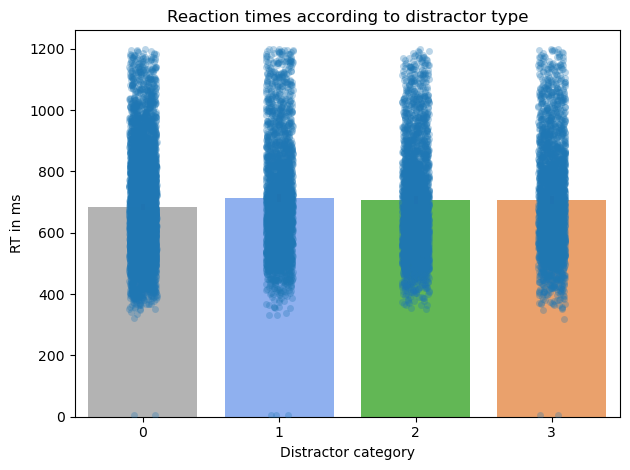

In [13]:
plt.figure()
sns.barplot(data=df, x='dist_id', y='reaction_time', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='reaction_time', alpha=0.3)
plt.title('Reaction times according to distractor type')
plt.ylabel('RT in ms')
plt.xlabel('Distractor category')
plt.tight_layout()
plt.show()

There seems to be outliers : we want to suppress trials with unphysiological reaction times (below 150 ms). 

In [14]:
df = df[df.reaction_time > 150]

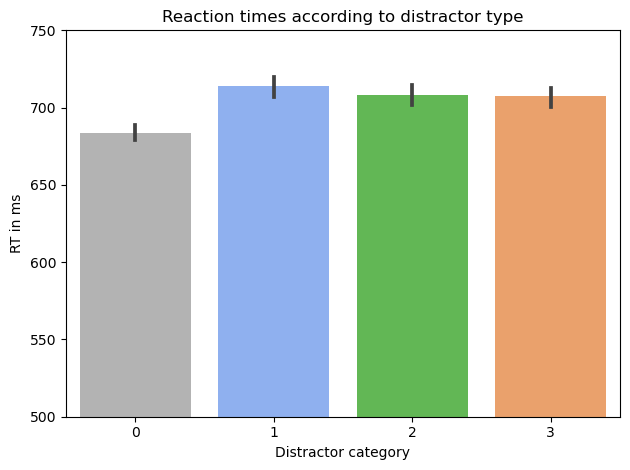

In [15]:
plt.figure()
sns.barplot(data=df, x='dist_id', y='reaction_time', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.title('Reaction times according to distractor type')
plt.ylim((500, 750))
plt.ylabel('RT in ms')
plt.xlabel('Distractor category')
plt.tight_layout()
plt.show()

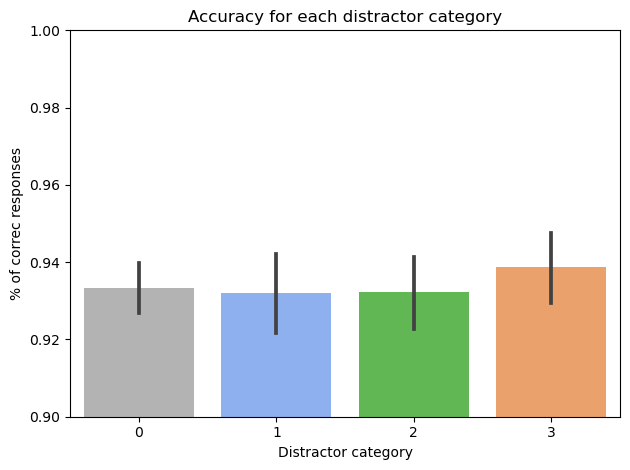

In [16]:
plt.figure()
sns.barplot(data=df, x='dist_id', y='correctness', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.title('Accuracy for each distractor category')
plt.ylabel('% of correc responses')
plt.xlabel('Distractor category')
plt.ylim((0.9, 1))
plt.tight_layout()
plt.show()

Globally, and as we have already seen via hypothesis testing, there is no effect of distractor type on behavioral measures (except a slightly faster reaction time without distractor). 

## Oculomotor data

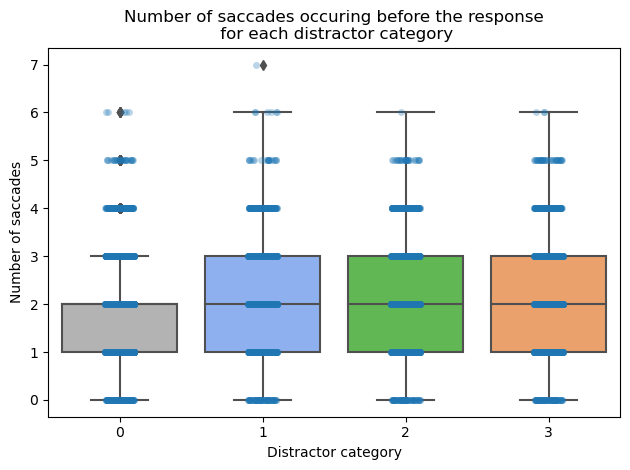

In [17]:
plt.figure()
sns.boxplot(data=df, x='dist_id', y='nb_sac_before_resp', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='nb_sac_before_resp', alpha=0.3)
plt.title('Number of saccades occuring before the response\n for each distractor category')
plt.ylabel('Number of saccades')
plt.xlabel('Distractor category')
plt.tight_layout()
plt.show()

Here again, we see some outliers, we will suppress the only outlier in category 1 and trials with 6 saccades in category 0 (since we see that it is very rare compared to trials with 4 or 5 saccades). 

In [18]:
df = df.drop(df[(df.dist_id == 0) & (df.nb_sac_before_resp > 5)].index)
df = df.drop(df[(df.dist_id == 1) & (df.nb_sac_before_resp > 6)].index)
df.shape

(13653, 36)

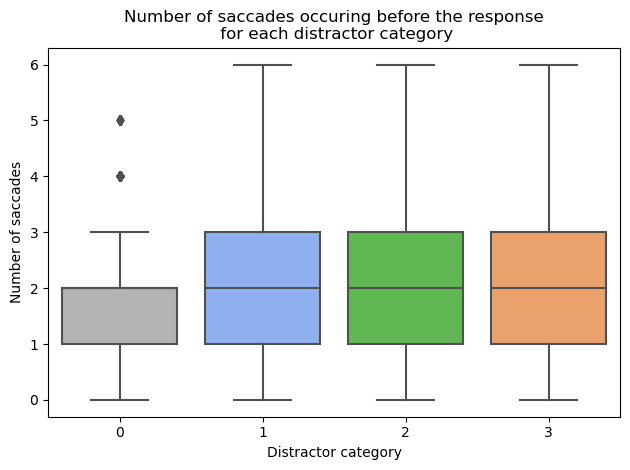

In [19]:
plt.figure()
sns.boxplot(data=df, x='dist_id', y='nb_sac_before_resp', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.title('Number of saccades occuring before the response\n for each distractor category')
plt.ylabel('Number of saccades')
plt.xlabel('Distractor category')
plt.tight_layout()
plt.show()

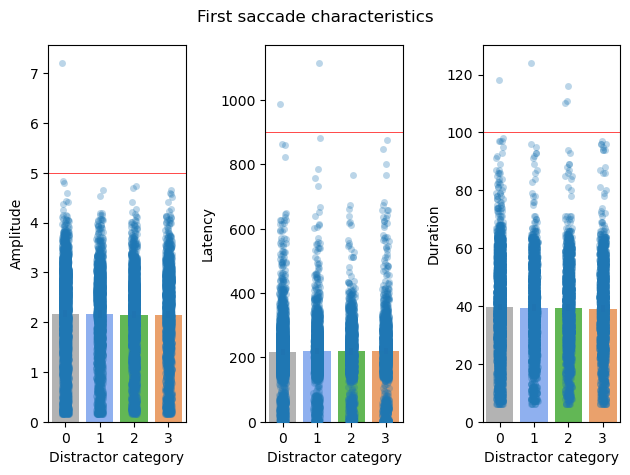

In [20]:
fig = plt.figure()
fig.add_subplot(131)
sns.barplot(data=df, x='dist_id', y='amplitude_1', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='amplitude_1', alpha=0.3)
plt.axhline(y=5, color='red', linewidth=0.5)
plt.ylabel('Amplitude')
plt.xlabel('Distractor category')
fig.add_subplot(132)
sns.barplot(data=df, x='dist_id', y='latency_1', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='latency_1', alpha=0.3)
plt.axhline(y=900, color='red', linewidth=0.5)
plt.ylabel('Latency')
plt.xlabel('Distractor category')
fig.add_subplot(133)
sns.barplot(data=df, x='dist_id', y='duration_1', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='duration_1', alpha=0.3)
plt.axhline(y=100, color='red', linewidth=0.5)
plt.ylabel('Duration')
plt.xlabel('Distractor category')
plt.suptitle('First saccade characteristics')
plt.tight_layout()
plt.show()

I will suppress the only outlier for amplitude, 2 outliers for latency and a few outliers for duration. 

In [21]:
df = df.drop(df[df.amplitude_1 > 5].index)  # it makes sense because items are displayed on a 5° radius circle
df = df.drop(df[df.latency_1 > 900].index)
df = df.drop(df[df.duration_1 > 100].index)
df.shape

(13645, 36)

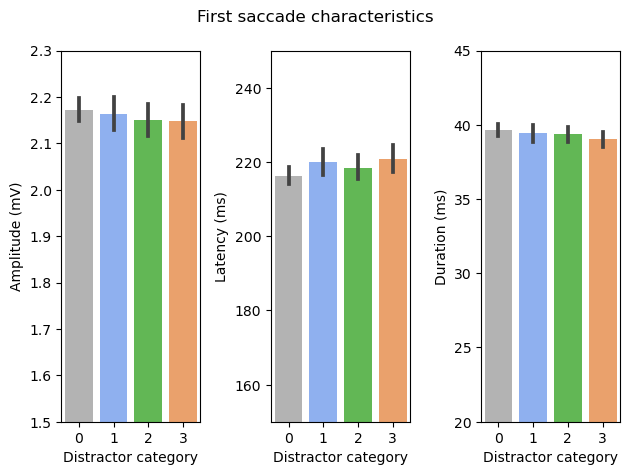

In [24]:
fig = plt.figure()
fig.add_subplot(131)
sns.barplot(data=df, x='dist_id', y='amplitude_1', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Amplitude (mV)')
plt.ylim((1.5, 2.3))
plt.xlabel('Distractor category')
fig.add_subplot(132)
sns.barplot(data=df, x='dist_id', y='latency_1', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Latency (ms)')
plt.ylim((150,250))
plt.xlabel('Distractor category')
fig.add_subplot(133)
sns.barplot(data=df, x='dist_id', y='duration_1', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Duration (ms)')
plt.ylim((20,45))
plt.xlabel('Distractor category')
plt.suptitle('First saccade characteristics')
plt.tight_layout()
plt.show()

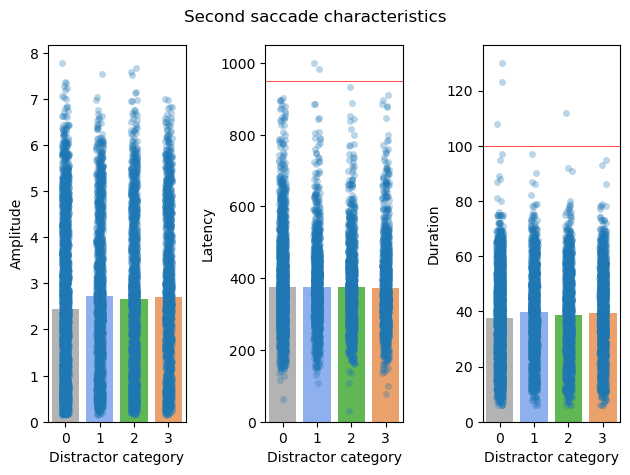

In [25]:
fig = plt.figure()
fig.add_subplot(131)
sns.barplot(data=df, x='dist_id', y='amplitude_2', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='amplitude_2', alpha=0.3)
plt.ylabel('Amplitude')
plt.xlabel('Distractor category')
fig.add_subplot(132)
sns.barplot(data=df, x='dist_id', y='latency_2', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='latency_2', alpha=0.3)
plt.axhline(y=950, color='red', linewidth=0.5)
plt.ylabel('Latency')
plt.xlabel('Distractor category')
fig.add_subplot(133)
sns.barplot(data=df, x='dist_id', y='duration_2', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='duration_2', alpha=0.3)
plt.axhline(y=100, color='red', linewidth=0.5)
plt.ylabel('Duration')
plt.xlabel('Distractor category')
plt.suptitle('Second saccade characteristics')
plt.tight_layout()
plt.show()

In [26]:
df = df.drop(df[df.latency_2 > 950].index)
df = df.drop(df[df.duration_2 > 100].index)
df.shape

(13639, 36)

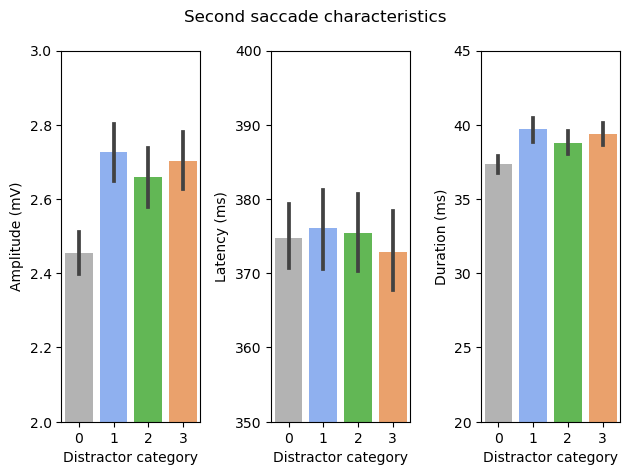

In [28]:
fig = plt.figure()
fig.add_subplot(131)
sns.barplot(data=df, x='dist_id', y='amplitude_2', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Amplitude (mV)')
plt.ylim((2, 3))
plt.xlabel('Distractor category')
fig.add_subplot(132)
sns.barplot(data=df, x='dist_id', y='latency_2', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Latency (ms)')
plt.ylim((350, 400))
plt.xlabel('Distractor category')
fig.add_subplot(133)
sns.barplot(data=df, x='dist_id', y='duration_2', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Duration (ms)')
plt.ylim((20,45))
plt.xlabel('Distractor category')
plt.suptitle('Second saccade characteristics')
plt.tight_layout()
plt.show()

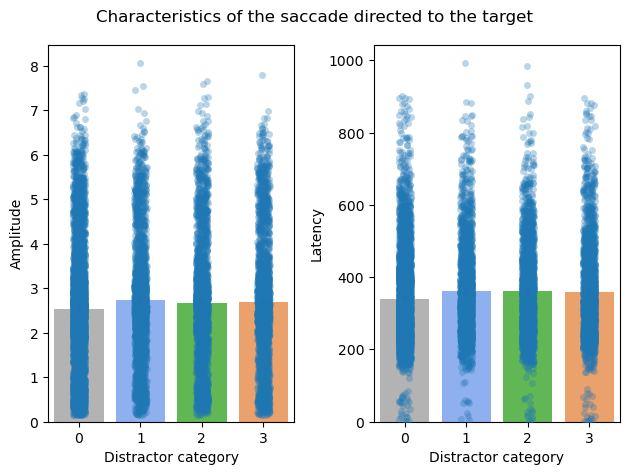

In [29]:
fig = plt.figure()
fig.add_subplot(121)
sns.barplot(data=df, x='dist_id', y='ampli_targ', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='ampli_targ', alpha=0.3)
plt.ylabel('Amplitude')
plt.xlabel('Distractor category')
fig.add_subplot(122)
sns.barplot(data=df, x='dist_id', y='lat_targ', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='lat_targ', alpha=0.3)
#plt.axhline(y=950, color='red', linewidth=0.5)
plt.ylabel('Latency')
plt.xlabel('Distractor category')
plt.suptitle('Characteristics of the saccade directed to the target')
plt.tight_layout()
plt.show()

I won't suppress anything here.

## EMG data

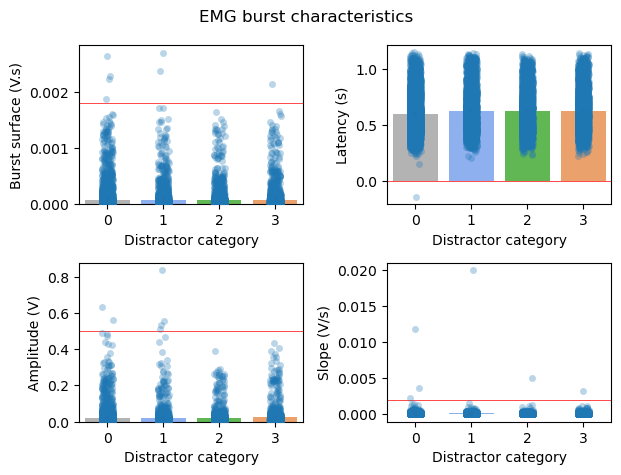

In [30]:
fig = plt.figure()
fig.add_subplot(221)
sns.barplot(data=df, x='dist_id', y='burst_surface', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='burst_surface', alpha=0.3)
plt.axhline(y=0.0018, color='red', linewidth=0.5)
plt.ylabel('Burst surface (V.s)')
plt.xlabel('Distractor category')
fig.add_subplot(222)
sns.barplot(data=df, x='dist_id', y='onset_latency', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='onset_latency', alpha=0.3)
plt.axhline(y=0, color='red', linewidth=0.5)
plt.ylabel('Latency (s)')
plt.xlabel('Distractor category')
fig.add_subplot(223)
sns.barplot(data=df, x='dist_id', y='toresp_sum', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='toresp_sum', alpha=0.3)
plt.axhline(y=.5, color='red', linewidth=0.5)
plt.ylabel('Amplitude (V)')
plt.xlabel('Distractor category')
fig.add_subplot(224)
sns.barplot(data=df, x='dist_id', y='slope', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
sns.stripplot(data=df, x='dist_id', y='slope', alpha=0.3)
plt.axhline(y=0.002, color='red', linewidth=0.5)
plt.ylabel('Slope (V/s)')
plt.xlabel('Distractor category')
plt.suptitle('EMG burst characteristics')
plt.tight_layout()
plt.show()

Obviously, negative latency is not possible, we want to suppress this value. 
We set thresholds for each value to suppress outliers. 

In [31]:
df = df.drop(df[df.onset_latency < 0].index)
df = df.drop(df[df.burst_surface > 0.0018].index)
df = df.drop(df[df.toresp_sum > 0.5].index)
df = df.drop(df[df.slope > 0.002].index)
df.shape

(13621, 36)

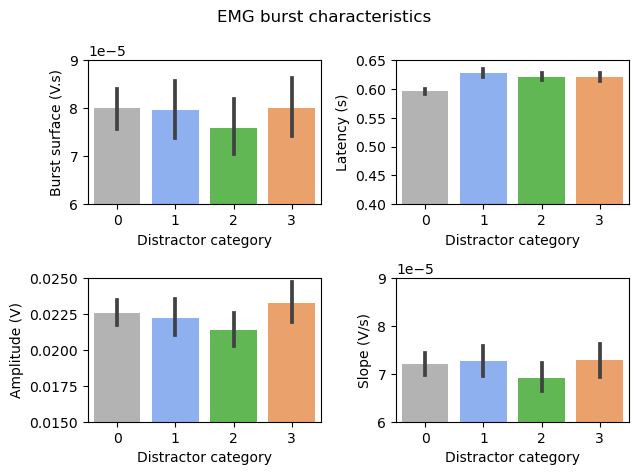

In [34]:
fig = plt.figure()
fig.add_subplot(221)
sns.barplot(data=df, x='dist_id', y='burst_surface', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Burst surface (V.s)')
plt.ylim(6e-5, 9e-5)
plt.xlabel('Distractor category')
fig.add_subplot(222)
sns.barplot(data=df, x='dist_id', y='onset_latency', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Latency (s)')
plt.ylim((0.4, 0.65))
plt.xlabel('Distractor category')
fig.add_subplot(223)
sns.barplot(data=df, x='dist_id', y='toresp_sum', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Amplitude (V)')
plt.ylim((0.015, 0.025))
plt.xlabel('Distractor category')
fig.add_subplot(224)
sns.barplot(data=df, x='dist_id', y='slope', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Slope (V/s)')
plt.ylim((6e-5, 9e-5))
plt.xlabel('Distractor category')
plt.suptitle('EMG burst characteristics')
plt.tight_layout()
plt.show()

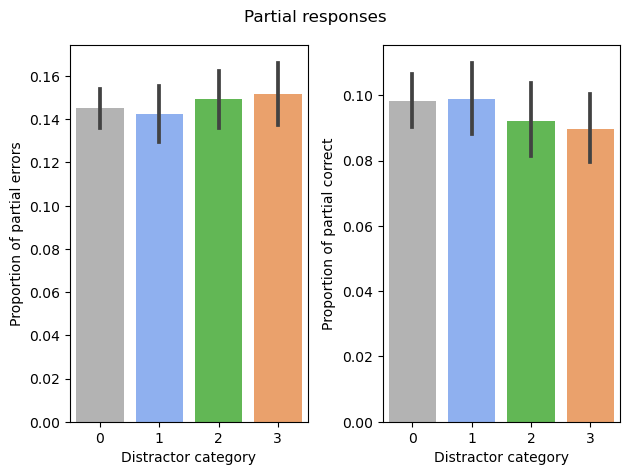

In [35]:
fig = plt.figure()
fig.add_subplot(121)
sns.barplot(data=df, x='dist_id', y='partial_error', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
#sns.stripplot(data=df, x='dist_id', y='partial_error', alpha=0.3)
#plt.axhline(y=0.0018, color='red', linewidth=0.5)
plt.ylabel('Proportion of partial errors')
plt.xlabel('Distractor category')
fig.add_subplot(122)
sns.barplot(data=df, x='dist_id', y='partial_correct', palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.ylabel('Proportion of partial correct')
plt.xlabel('Distractor category')
plt.suptitle('Partial responses')
plt.tight_layout()
plt.show()

In [41]:
# save data containing only "true" and relevant variables
df.to_csv('clean_data_oneEMG.csv', index=False)

# MODELS

Different models (Youssef Trardi's code) that will be trained and tested on our data, and performance measure. 


In [42]:
#=======================================================================================
# AdaBClassifier ===========================================================
#=======================================================================================
paramsadb = {}
m = 0
for maxdepth in np.arange(1,5):
    for learningrate in [0.3, 0.5, 0.7]: # 0.1 : 1
        for nestimators in np.arange(10,102,2):
            paramsadb[m] = {'n_estimators':nestimators, 
                      'base_estimator':DecisionTreeClassifier(max_depth=maxdepth),
                      'learning_rate':learningrate}
            m = m + 1                
rangeadb = list(paramsadb.keys())
def adaboostclassifier(simulation, xapp, yapp, xval, yval, metrics_eval): 
    global df_metrics, supmetrics 
    df_metrics = pd.DataFrame()
    for k in rangeadb:
        params = paramsadb[k]
        clf = AdaBoostClassifier(random_state=0)
        clf.set_params(**params)
        clf.fit(xapp,yapp)
        ypreda = clf.predict(xapp)
        ypredv = clf.predict(xval) 
        sc = scores(ypreda, yapp, ypredv, yval, str('AdaBoostClassifier & hyperparams = ' + str(params)))
        df_metrics = pd.concat([df_metrics, sc], axis=0, ignore_index=True)  
        if supmetrics < sc[metrics_eval][0]:
            supmetrics = sc[metrics_eval][0]
            print(" ======> Running AdaBoostClassifier classifier for %s variables" % np.shape(xapp)[1])
            print(" ====== Running AdaBoostClassifier for  = %s" % params)
            print(" ======> Running %s ======> " % simulation)
            print()
            print("**************** Validation ****************")
            print()
            print('classification report')
            print(pd.DataFrame(classification_report(yval, ypredv, output_dict=True)).transpose())
            print()
            print('confusion matrix')
            print(confusion_matrix(yval, ypredv))
            print()
            print('Precision = %s ' % sc["precision-val"][0])
            print('Sensitivity = %s ' % sc["recall-val"][0])
            print('Specificity = %s ' % sc["specificity-val"][0])
            print('F-measure = %s ' % sc["fscore-val"][0])
            print('Accuracy = %s ' % sc["accuracy-val"][0])
            print('misclassification = %s ' % sc["misclassified-val"][0])
            print()
    df_metrics.insert(1, 'indices',  list(np.repeat(simulation, np.shape(df_metrics)[0], axis=0)))  
    return df_metrics



In [43]:
#=======================================================================================
# ExtraTreesClassifier ===========================================================
#=======================================================================================
paramsaetc = {}
m = 0
for maxdepth in np.concatenate((np.arange(1,5), [None]), axis=0):
    for criterion in ["gini","entropy"]:
        for maxfeatures in ['sqrt', 'log2', None]:  #'auto' raised an error, had to change to ['sqrt', 'log2', 'none']
            for nestimators in np.arange(10,102,2):
                paramsaetc[m] = {'n_estimators':nestimators, 
                          'max_features': maxfeatures,
                          'max_depth':maxdepth,
                          'criterion':criterion}
                m = m + 1                
rangeetc = list(paramsaetc.keys())
def extratreesclassifier(simulation, xapp, yapp, xval, yval, metrics_eval): 
    global df_metrics, supmetrics 
    df_metrics = pd.DataFrame()
    for k in rangeetc:
        params = paramsaetc[k]
        clf = ExtraTreesClassifier(random_state=0)
        clf.set_params(**params)
        clf.fit(xapp,yapp)
        ypreda = clf.predict(xapp)
        ypredv = clf.predict(xval)  
        sc = scores(ypreda, yapp, ypredv, yval, str('ExtraTreesClassifier & hyperparams = ' + str(params)))
        df_metrics = pd.concat([df_metrics, sc], axis=0, ignore_index=True) 
        if supmetrics < sc[metrics_eval][0]:
            supmetrics = sc[metrics_eval][0]
            print(" ======> Running ExtraTreesClassifier classifier for %s variables" % np.shape(xapp)[1])
            print(" ====== Running ExtraTreesClassifier for  = %s" % params)
            print(" ======> Running %s ======> " % simulation)
            print()
            print("**************** Validation ****************")
            print()
            print('classification report')
            print(pd.DataFrame(classification_report(yval, ypredv, output_dict=True)).transpose())
            print()
            print('confusion matrix')
            print(confusion_matrix(yval, ypredv))
            print()
            print('Precision = %s ' % sc["precision-val"][0])
            print('Sensitivity = %s ' % sc["recall-val"][0])
            print('Specificity = %s ' % sc["specificity-val"][0])
            print('F-measure = %s ' % sc["fscore-val"][0])
            print('Accuracy = %s ' % sc["accuracy-val"][0])
            print('misclassification = %s ' % sc["misclassified-val"][0])
            print()
    df_metrics.insert(1, 'indices',  list(np.repeat(simulation, np.shape(df_metrics)[0], axis=0)))  
    return df_metrics

In [44]:
#=======================================================================================
# RandomForestClassifier ===========================================================
#=======================================================================================
paramsarfc= {}
m = 0
for maxdepth in np.concatenate(([None], np.arange(1,6)), axis=0):
    for criterion in ["gini","entropy"]:
        for nestimators in np.arange(10,102,2):
            for maxfeatures in ['sqrt', 'log2', None]:  #'auto' raised an error, had to change to ['sqrt', 'log2', 'none']
                paramsarfc[m] = {'n_estimators':nestimators, 
                          'max_features': maxfeatures,
                          'max_depth':maxdepth,
                          'criterion':criterion}
                m = m + 1  
rangerfc = list(paramsarfc.keys())
def randomforestclassifier(simulation, xapp, yapp, xval, yval, metrics_eval): 
    global df_metrics, supmetrics 
    df_metrics = pd.DataFrame()
    for k in rangerfc:
        params = paramsarfc[k]
        clf = RandomForestClassifier(random_state=0)
        clf.set_params(**params)
        clf.fit(xapp,yapp)
        ypreda = clf.predict(xapp)
        ypredv = clf.predict(xval) 
        sc = scores(ypreda, yapp, ypredv, yval, str('RandomForestClassifier & hyperparams = ' + str(params)))
        df_metrics = pd.concat([df_metrics, sc], axis=0, ignore_index=True) 
        if supmetrics < sc[metrics_eval][0]:
            supmetrics = sc[metrics_eval][0]
            print(" ======> Running RandomForestClassifier classifier for %s variables" % np.shape(xapp)[1])
            print(" ====== Running RandomForestClassifier for  = %s" % params)
            print(" ======> Running %s ======> " % simulation)
            print()
            print("**************** Validation ****************")
            print()
            print('classification report')
            print(pd.DataFrame(classification_report(yval, ypredv, output_dict=True)).transpose())
            print()
            print('confusion matrix')
            print(confusion_matrix(yval, ypredv))
            print()
            print('Precision = %s ' % sc["precision-val"][0])
            print('Sensitivity = %s ' % sc["recall-val"][0])
            print('Specificity = %s ' % sc["specificity-val"][0])
            print('F-measure = %s ' % sc["fscore-val"][0])
            print('Accuracy = %s ' % sc["accuracy-val"][0])
            print('misclassification = %s ' % sc["misclassified-val"][0])
            print()
    df_metrics.insert(1, 'indices',  list(np.repeat(simulation, np.shape(df_metrics)[0], axis=0)))  
    return df_metrics

In [45]:
#=======================================================================================
# XGBoostClassifier ===========================================================
#=======================================================================================
paramsaxgb= {}
m = 0
for maxdepth in np.arange(3,6):
    for subsample in [0.5, 0.75, 1]:
        for treemethod in ['auto', 'hist']:
            for learningrate in [0.1, 0.3, 0.5, 0.7, 1]:
                for nestimators in np.arange(200,410,10):
                    paramsaxgb[m] = {'n_estimators':nestimators,
                              'max_depth':maxdepth,
                              'eta':learningrate,
                              'tree_method':treemethod,
                              'booster':'gbtree',
                              'sampling_method':'uniform',
                              'subsample':subsample,
                              'eval_metric':['logloss']}
                    m = m + 1 
rangexgb = list(paramsaxgb.keys())

def xgboostclassifier(simulation, xapp, yapp, xval, yval, metrics_eval):
    global df_metrics, supmetrics
    df_metrics = pd.DataFrame()
    for k in random.choices(rangexgb):
        params = paramsaxgb[k]
        clf = None
        clf = xgb.XGBClassifier()
        clf.set_params(**params)
        clf.fit(xapp,yapp)
        ypreda = clf.predict(xapp)
        ypredv = clf.predict(xval)
        sc = scores(ypreda, yapp, ypredv, yval, str('XGBoost & hyperparams = ' + str(params)))
        df_metrics = pd.concat([df_metrics, sc], axis=0, ignore_index=True) 
        if supmetrics < sc[metrics_eval][0]:
            supmetrics = sc[metrics_eval][0]
            print(" ======> Running XGBoost classifier for %s variables" % np.shape(xapp)[1])
            print(" ====== Running XGBoost for  = %s" % params)
            print(" ======> Running %s ======> " % simulation)
            print()
            print("**************** Validation ****************")
            print()
            print('classification report')
            print(pd.DataFrame(classification_report(yval, ypredv, output_dict=True)).transpose())
            print()
            print('confusion matrix')
            print(confusion_matrix(yval, ypredv))
            print()
            print('Precision = %s ' % sc["precision-val"][0])
            print('Sensitivity = %s ' % sc["recall-val"][0])
            print('Specificity = %s ' % sc["specificity-val"][0])
            print('F-score = %s ' % sc["fscore-val"][0])
            print('Accuracy = %s ' % sc["accuracy-val"][0])
            #print('Balanced_Accuracy = %s ' % sc["bacc-val"][0])
    df_metrics.insert(1, 'indices',  list(np.repeat(simulation, np.shape(df_metrics)[0], axis=0))) 

    return df_metrics

## Models evaluation

In [46]:
#=================================================================================
# Metrics ========================================================================
#=================================================================================
def confusionmatrix(y_true, y_pred):    
    if len(np.unique(y_true)) <= 2:
        # create confusion matrix
        conf_mat = confusion_matrix(y_true, y_pred)
        # calculate overall accuracy
        accuracy = accuracy_score(y_true, y_pred)
        # calculate overall precision
        precision = precision_score(y_true, y_pred)
        # calculate overall recall (sensitivity)
        recall = recall_score(y_true, y_pred)
        # calculate overall f1-score
        fmeasure = f1_score(y_true, y_pred)
        # calculate specificity
        specificity = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1])
    else:
        # create confusion matrix
        conf_mat = confusion_matrix(y_true, y_pred)
        # calculate overall accuracy
        accuracy = accuracy_score(y_true, y_pred)
        # calculate overall precision
        precision = precision_score(y_true, y_pred, average='macro')
        # calculate overall recall (sensitivity)
        recall = recall_score(y_true, y_pred, average='macro')
        # calculate overall f1-score (weighted average of precision and recall)
        fmeasure = f1_score(y_true, y_pred, average='macro')
        # calculate overall specificity
        specificity_ = []
        for i in range(conf_mat.shape[0]):
            true_negatives = sum(conf_mat[:, i]) - conf_mat[i, i]
            false_positives = sum(conf_mat[i, :]) - conf_mat[i, i]
            specificity_.append(true_negatives / (true_negatives + false_positives))
        specificity = sum(specificity_) / len(specificity_)
    return precision*100, recall*100, specificity*100, fmeasure*100, accuracy*100, conf_mat

In [47]:
#=================================================================================
# scores =========================================================================
#=================================================================================
def scores(ypreda, yapp, ypredt, ytest, params):  
    classificationreport = pd.DataFrame({'CLF Configuration': [],
                                         'precision-train': [], 'recall-train': [], 'specificity-train': [], 'fscore-train': [], 'accuracy-train': [], 'misclassified-train': [],
                                         'precision-val':  [], 'recall-val':  [], 'specificity-val':  [], 'fscore-val':  [], 'accuracy-val':  [], 'misclassified-val':  []})
    app = confusionmatrix(yapp, ypreda)
    test = confusionmatrix(ytest, ypredt)
    cmapp = int(app[5].sum()-sum(np.diag(app[5])))
    cmtest = int(test[5].sum()-sum(np.diag(test[5])))
    new_row = pd.DataFrame({'CLF Configuration': [params],
                            'precision-train': [app[0].round(4)], 'recall-train': [app[1].round(4)], 'specificity-train': [app[2].round(4)], 
                            'fscore-train': [app[3].round(4)], 'accuracy-train': [app[4].round(4)], 'misclassified-train': [cmapp],
                            'precision-val': [test[0].round(4)], 'recall-val': [test[1].round(4)], 'specificity-val': [test[2].round(4)], 
                            'fscore-val': [test[3].round(4)], 'accuracy-val': [test[4].round(4)], 'misclassified-val':  [cmtest]})
    classificationreport = pd.concat([classificationreport, new_row], axis=0, ignore_index=True)   
    return classificationreport 

In [48]:
def conf_mat(yval, ypredv, clf):
    cm = confusion_matrix(yval, ypredv, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

# STEP 1 - strict preprocessing & basic train-test split

In [49]:
df = pd.read_csv('clean_data_oneEMG.csv')
df.head()

,dist_id,correctness,reaction_time,nb_sac,nb_sac_before_resp,amplitude_1,latency_1,duration_1,amplitude_2,latency_2,duration_2,ampli_targ,lat_targ,th_sacc_target,subj,peak_amplitude,peak_latency,onset_latency,offset_latency,burst_duration,burst_surface,burst_avg,slope,mt,burst_sum,topeak_sum,toresp_sum,ct,avg_ic,avg_cc,surface_ic,surface_cc,ic_latency,cc_latency,partial_error,partial_correct
0,0,0,846.9798,4.0,4.0,0.219146,35.0,10.0,2.843148,245.0,45.0,0.219146,35.0,1,1.0,0.002914,1.616,0.781,1.723,0.942,0.000400,0.000425,5.112471e-05,0.066,0.400589,0.325820,0.021042,0.197,NaN,0.000022,NaN,6.875027e-07,NaN,0.584,0,1
1,0,0,1089.1369,3.0,3.0,2.514761,178.0,45.0,0.617821,440.0,23.0,2.656926,546.0,3,1.0,0.001542,1.075,0.949,1.347,0.398,0.000163,0.000410,5.131321e-07,0.141,0.163223,0.017407,0.026719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3,1,1092.7854,6.0,5.0,2.566948,177.0,48.0,4.726215,377.0,60.0,4.438476,474.0,3,1.0,0.002273,1.086,1.035,1.372,0.337,0.000167,0.000495,1.726532e-04,0.058,0.166900,0.018180,0.026424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,0,1,1022.2735,2.0,2.0,3.384380,214.0,52.0,3.458086,347.0,51.0,3.458086,347.0,2,1.0,0.001190,1.006,0.917,1.332,0.415,0.000108,0.000260,7.318844e-05,0.106,0.107944,0.016898,0.024556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,1,1,1161.5520,4.0,3.0,2.047059,279.0,40.0,3.762648,407.0,50.0,3.762648,407.0,2,1.0,0.002854,1.373,1.025,1.487,0.462,0.000301,0.000651,4.787798e-05,0.138,0.300690,0.234798,0.039347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [50]:
#df = df[df.correctness == 1]  # only correct responses 
print(f'The clean dataset contains {df.shape[0]} observations and {df.shape[1]-1} variables.')

The clean dataset contains 13621 observations and 35 variables.


## Deal with missing values

Suppress feature if > 5% missing, and suppress rows with one missing value. 

In [51]:
nombre_missing = df.isnull().sum()
nombre_missing.sort_values(ascending=False)

avg_cc                12321
surface_cc            12321
cc_latency            12321
avg_ic                11623
surface_ic            11623
ic_latency            11623
ct                    10323
amplitude_2            6150
latency_2              6150
duration_2             6150
lat_targ               2760
ampli_targ             2760
duration_1             2345
latency_1              2345
amplitude_1            2345
nb_sac_before_resp     1963
nb_sac                  323
slope                   253
toresp_sum              253
topeak_sum              253
burst_sum               253
mt                      253
offset_latency          253
burst_avg               253
burst_surface           253
burst_duration          253
onset_latency           253
peak_latency            253
peak_amplitude          253
partial_error             0
dist_id                   0
correctness               0
subj                      0
th_sacc_target            0
reaction_time             0
partial_correct     

In [52]:
pourcentage_missing = df.isnull().mean() * 100
colonnes_a_supprimer = pourcentage_missing[pourcentage_missing > 5].index  # we use a threshold of 5%
print('columns to delete:\n', colonnes_a_supprimer)
df.drop(colonnes_a_supprimer, axis=1, inplace=True)

print('remaining columns:\n', df.columns)

print('dataset shape after deleting features:', df.shape)

columns to delete:
 Index(['nb_sac_before_resp', 'amplitude_1', 'latency_1', 'duration_1',
       'amplitude_2', 'latency_2', 'duration_2', 'ampli_targ', 'lat_targ',
       'ct', 'avg_ic', 'avg_cc', 'surface_ic', 'surface_cc', 'ic_latency',
       'cc_latency'],
      dtype='object')
remaining columns:
 Index(['dist_id', 'correctness', 'reaction_time', 'nb_sac', 'th_sacc_target',
       'subj', 'peak_amplitude', 'peak_latency', 'onset_latency',
       'offset_latency', 'burst_duration', 'burst_surface', 'burst_avg',
       'slope', 'mt', 'burst_sum', 'topeak_sum', 'toresp_sum', 'partial_error',
       'partial_correct'],
      dtype='object')
dataset shape after deleting features: (13621, 20)


The problem is that missing values for variables concerning EMG correspond to trials in which we are supposed to reject EMG (noise in the signal). But I feel we can still use behavioral and eye movement data... Same issue for nb_sac variable, missing values corresponds to trials previously marked as bad for eye movement measures (variable eyeOK was removed in the beginning).

In [53]:
nombre_missing = df.isnull().sum()
nombre_missing.sort_values(ascending=False)

nb_sac             323
burst_duration     253
mt                 253
toresp_sum         253
topeak_sum         253
peak_amplitude     253
peak_latency       253
onset_latency      253
offset_latency     253
burst_sum          253
burst_surface      253
burst_avg          253
slope              253
partial_error        0
dist_id              0
correctness          0
subj                 0
th_sacc_target       0
reaction_time        0
partial_correct      0
dtype: int64

Still a few missing values: we delete the rows instead of columns, because it corresponds to less than 5% of missing values. 

In [54]:
df.dropna(inplace=True) # because it corresponds to trials with noisy signal either in eye movements or in emg
print('dataset shape after rows removing:', df.shape)

dataset shape after rows removing: (13050, 20)


## Variables correlation

Suppress one of two correlated variables if correlation score > 0.7. 

In [55]:
class_target = df.dist_id
# remove the target column from dataset
x = df.drop('dist_id', axis=1, inplace=False)

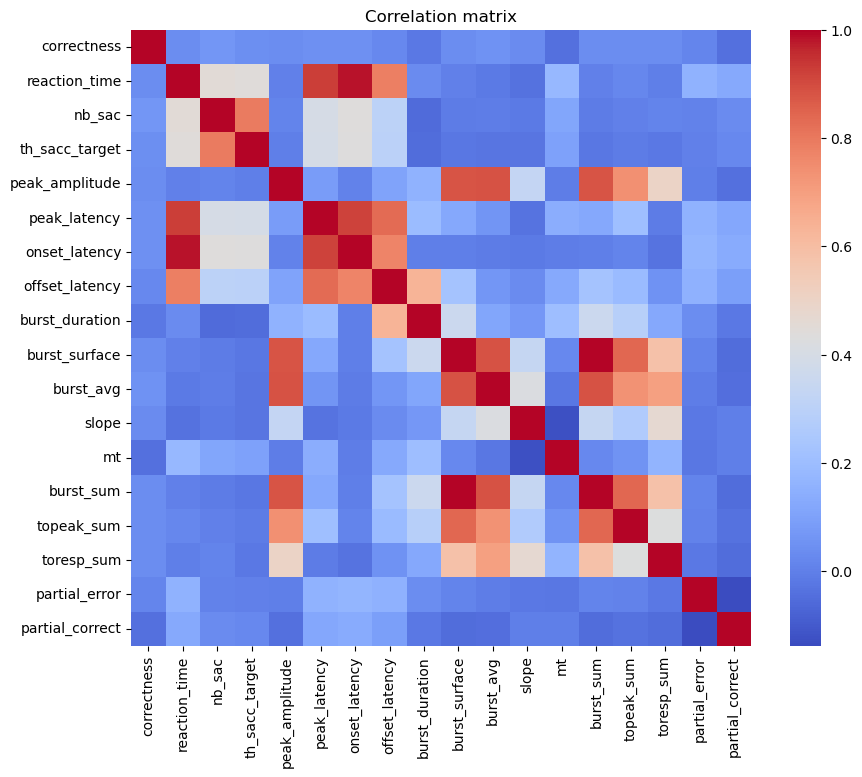

In [56]:
matrice_correlation = x.drop(['subj'], axis=1, inplace=False).corr()

# Visualisation : Heatmap de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_correlation, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix')
plt.show()

In [57]:
corr_details = matrice_correlation[abs(matrice_correlation) > 0.7]

variables_corr = []
for colonne in corr_details.columns:
    variables_corr.extend([(colonne, index) for index in corr_details.index if corr_details.loc[index, colonne] < 1.0])

variables_corr = list(set(tuple(sorted(paire)) for paire in variables_corr))
#len(variables_corr)

print('correlated pairs of variables:\n', variables_corr)

correlated pairs of variables:
 [('burst_avg', 'topeak_sum'), ('burst_surface', 'topeak_sum'), ('offset_latency', 'reaction_time'), ('burst_avg', 'burst_surface'), ('offset_latency', 'peak_latency'), ('onset_latency', 'reaction_time'), ('peak_amplitude', 'topeak_sum'), ('burst_sum', 'burst_surface'), ('onset_latency', 'peak_latency'), ('nb_sac', 'th_sacc_target'), ('burst_avg', 'peak_amplitude'), ('offset_latency', 'onset_latency'), ('burst_sum', 'peak_amplitude'), ('peak_latency', 'reaction_time'), ('burst_surface', 'peak_amplitude'), ('burst_avg', 'burst_sum'), ('burst_sum', 'topeak_sum')]


In [58]:
correlation_matrix = x.corr()

high_correlation = np.abs(correlation_matrix) >= 0.7  # threshold for correlation = 70%
columns_to_drop = []

for i in range(len(high_correlation.columns)):
    for j in range(i+1, len(high_correlation.columns)):
        if high_correlation.iloc[i, j]:
            column_i = high_correlation.columns[i]
            column_j = high_correlation.columns[j]
            
            if column_i not in columns_to_drop:
                columns_to_drop.append(column_j)

In [59]:
print('columns tro drop:\n', columns_to_drop)

columns tro drop:
 ['peak_latency', 'onset_latency', 'offset_latency', 'th_sacc_target', 'burst_surface', 'burst_avg', 'burst_sum', 'topeak_sum']


In [60]:
df_cleaned = df.drop(columns=columns_to_drop)

In [61]:
df_cleaned.shape

(13050, 12)

In [62]:
df_cleaned.head()

,dist_id,correctness,reaction_time,nb_sac,subj,peak_amplitude,burst_duration,slope,mt,toresp_sum,partial_error,partial_correct
0,0,0,846.9798,4.0,1.0,0.002914,0.942,5.112471e-05,0.066,0.021042,0,1
1,0,0,1089.1369,3.0,1.0,0.001542,0.398,5.131321e-07,0.141,0.026719,0,0
2,3,1,1092.7854,6.0,1.0,0.002273,0.337,1.726532e-04,0.058,0.026424,0,0
3,0,1,1022.2735,2.0,1.0,0.001190,0.415,7.318844e-05,0.106,0.024556,0,0
4,1,1,1161.5520,4.0,1.0,0.002854,0.462,4.787798e-05,0.138,0.039347,0,0


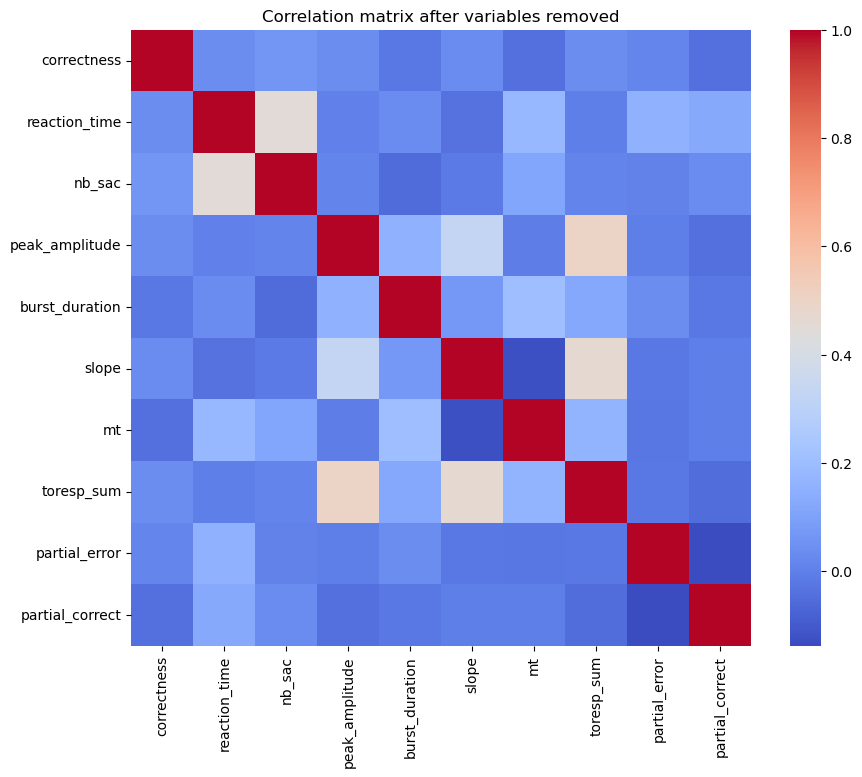

In [63]:
matrice_correlation2 = df_cleaned.drop(['dist_id', 'subj'], axis=1, inplace=False).corr()

# Visualisation : Heatmap de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_correlation2, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix after variables removed')
plt.show()

In [64]:
print(f'The final dataset contains {df_cleaned.shape[0]} observations and {df_cleaned.shape[1]-1} variables.')

The final dataset contains 13050 observations and 11 variables.


In [65]:
# save cleaned dataset for step1
df_cleaned.drop(['subj'], axis=1, inplace=False).to_csv('./Iteration1/clean_nomissing_nocorr_data.csv', index=False)
df_cleaned.to_csv('./Iteration2/clean_nomissing_nocorr_data.csv', index=False)


To sum up, the first data cleaning steps were:
- we suppressed irrelevant columns (duplicates, meaningless columns, info about participant or trial type...), it is mostly based on prior knowledge about the dataset
- we recoded the partial response variable and made one variable for the presence of partial error, one for presence of partial correct response and one for EMG rejection
- we suppressed variables containing too many missing values (more than 5%), and it is mostly because of no measure (no partial response, no second saccade, etc)
- we suppressed highly correlated variable (> 0.7 for correlation score)

## Train-test split

In [66]:
data1 = pd.read_csv('./Iteration1/clean_nomissing_nocorr_data.csv')

In [67]:
data1.shape

(13050, 11)

In [68]:
data1.isnull().sum()

dist_id            0
correctness        0
reaction_time      0
nb_sac             0
peak_amplitude     0
burst_duration     0
slope              0
mt                 0
toresp_sum         0
partial_error      0
partial_correct    0
dtype: int64

In [69]:
data1.head()

,dist_id,correctness,reaction_time,nb_sac,peak_amplitude,burst_duration,slope,mt,toresp_sum,partial_error,partial_correct
0,0,0,846.9798,4.0,0.002914,0.942,5.112471e-05,0.066,0.021042,0,1
1,0,0,1089.1369,3.0,0.001542,0.398,5.131321e-07,0.141,0.026719,0,0
2,3,1,1092.7854,6.0,0.002273,0.337,1.726532e-04,0.058,0.026424,0,0
3,0,1,1022.2735,2.0,0.001190,0.415,7.318844e-05,0.106,0.024556,0,0
4,1,1,1161.5520,4.0,0.002854,0.462,4.787798e-05,0.138,0.039347,0,0


In [70]:
# 70% train set - 30% test set
ydata = data1['dist_id']
xdata = data1.drop(['dist_id'], axis=1, inplace=False)

70% of the dataset becomes the train set, and we keep only 30% to test models. 

In [71]:
xapp, xval, yapp, yval = train_test_split(xdata, ydata, train_size=0.7, random_state=rs, stratify=ydata)

In [72]:
unique, counts = np.unique(yapp, return_counts=True)
print("Training   : ", counts)
unique, counts = np.unique(yval, return_counts=True)
print("Validation : ", counts)

Training   :  [3695 1795 1807 1838]
Validation :  [1584  770  774  787]


In [73]:
#flattens the array
yapp = np.ravel(yapp)
yval = np.ravel(yval)
#Scale numeric data 
scaler = RobustScaler().fit(xapp)
xappr = pd.DataFrame(scaler.transform(xapp))
xvalr = pd.DataFrame(scaler.transform(xval))

## Visualisation of data

In [74]:
pca = PCA()
pca.fit(xappr)
data_pca = pd.DataFrame(pca.transform(xappr))

data_pca_tot = pd.concat([data_pca, pd.DataFrame(yapp, columns=['dist_id'])], axis=1)

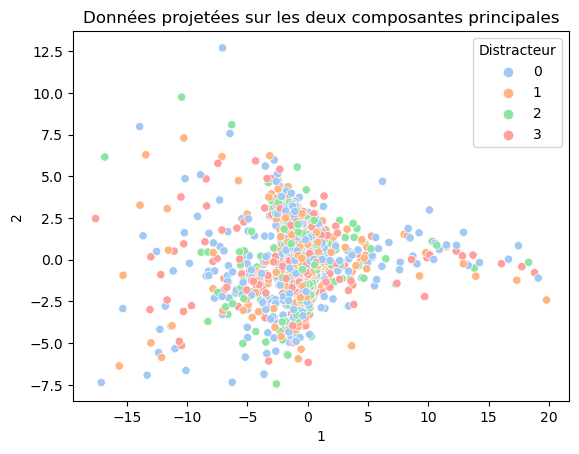

In [75]:
plt.figure()
plt.title('Données projetées sur les deux composantes principales')
sns.scatterplot(data=data_pca_tot, 
                x=1, 
                y=2,
                hue="dist_id", palette='pastel')
plt.legend(title='Distracteur')
plt.show()

## Briefly evaluate models performance 
In this step, we do not tune the models but we just want to see basic performance of each algorithm that we test. 
We will train them on the train set and then use its performance on test set. 

In [76]:
df_metrics_step1 = pd.DataFrame()

In [77]:
dummy_random = DummyClassifier(strategy="uniform")
dummy_random.fit(xappr, yapp)
ypreda = dummy_random.predict(xappr)
ypredv = dummy_random.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy_random')
df_metrics_step1 = pd.concat([df_metrics_step1, sc], axis=0, ignore_index=True)

Random dummy:



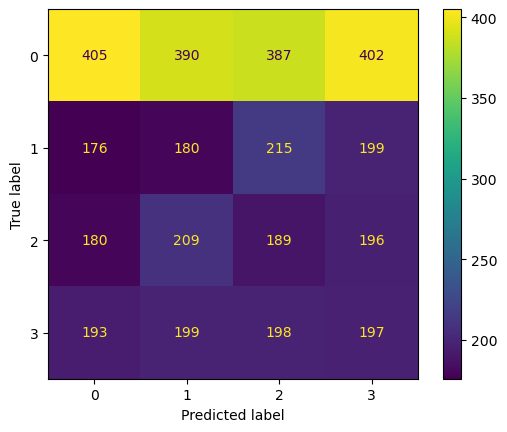

In [78]:
print('Random dummy:\n')
conf_mat(yval, ypredv, dummy_random)

Most frequent dummy:



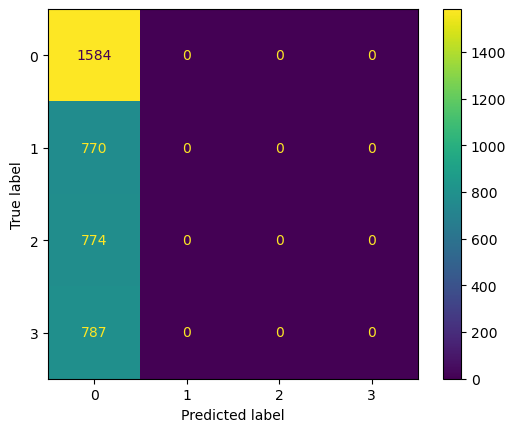

In [79]:
dummy_maj = DummyClassifier(strategy="most_frequent")
dummy_maj.fit(xappr, yapp)
ypreda = dummy_maj.predict(xappr)
ypredv = dummy_maj.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy most frequent')
df_metrics_step1 = pd.concat([df_metrics_step1, sc], axis=0, ignore_index=True)
print('Most frequent dummy:\n')
conf_mat(yval, ypredv, dummy_maj)

Adaboost:



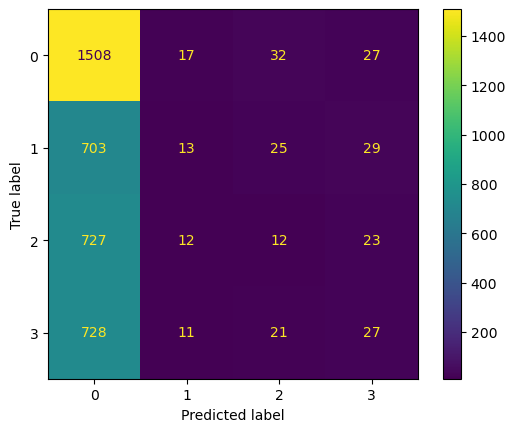

In [80]:
adaboost = AdaBoostClassifier(random_state=0).fit(xappr, yapp)
ypreda = adaboost.predict(xappr)
ypredv = adaboost.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'AdaBoostClassifier')
df_metrics_step1 = pd.concat([df_metrics_step1, sc], axis=0, ignore_index=True)
print('Adaboost:\n')
conf_mat(yval, ypredv, adaboost)

ExtraTrees:



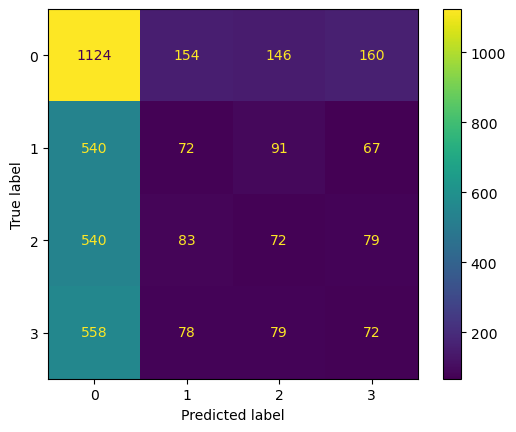

In [81]:
extratrees = ExtraTreesClassifier(random_state=0).fit(xappr, yapp)
ypreda = extratrees.predict(xappr)
ypredv = extratrees.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'ExtraTreesClassifier')
df_metrics_step1 = pd.concat([df_metrics_step1, sc], axis=0, ignore_index=True)
print('ExtraTrees:\n')
conf_mat(yval, ypredv, extratrees)

RandomForest:



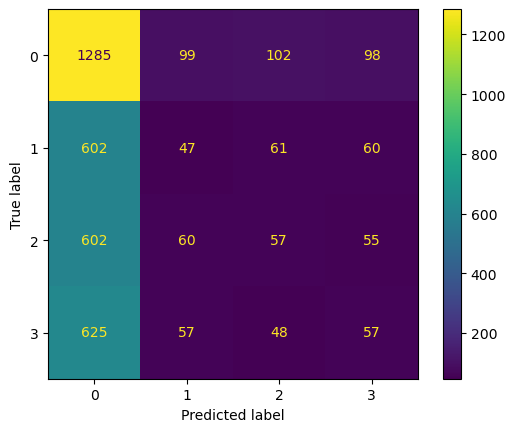

In [82]:
rf = RandomForestClassifier(random_state=0).fit(xappr, yapp)
ypreda = rf.predict(xappr)
ypredv = rf.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'RandomForectClassifier')
df_metrics_step1 = pd.concat([df_metrics_step1, sc], axis=0, ignore_index=True)
print('RandomForest:\n')
conf_mat(yval, ypredv, rf)

XGBoost:



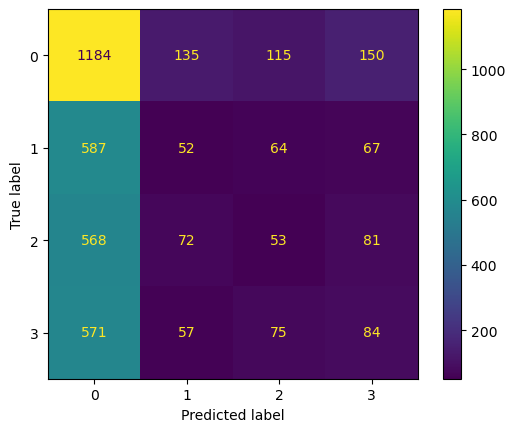

In [83]:
xg = xgb.XGBClassifier().fit(xappr, yapp)
ypreda = xg.predict(xappr)
ypredv = xg.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'XGBoostClassifier')
df_metrics_step1 = pd.concat([df_metrics_step1, sc], axis=0, ignore_index=True)
print('XGBoost:\n')
conf_mat(yval, ypredv, xg)

In [84]:
df_metrics_step1

,CLF Configuration,precision-train,recall-train,specificity-train,fscore-train,accuracy-train,misclassified-train,precision-val,recall-val,specificity-val,fscore-val,accuracy-val,misclassified-val
0,dummy_random,24.8934,24.7891,51.1924,24.2096,24.9918,6852.0,24.9467,24.5988,51.1219,24.0182,24.8020,2944.0
1,dummy most frequent,10.1122,25.0000,25.0000,14.3998,40.4488,5440.0,10.1149,25.0000,25.0000,14.4026,40.4598,2331.0
2,AdaBoostClassifier,37.5895,26.8875,29.3146,19.7004,41.1056,5380.0,26.1170,25.4679,30.0796,17.3579,39.8467,2355.0
3,ExtraTreesClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,24.2260,24.6903,42.5455,22.2312,34.2273,2575.0
4,RandomForectClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,25.3789,25.4587,38.5692,21.3824,36.9349,2469.0
5,XGBoostClassifier,89.6333,76.2380,30.7199,80.4828,81.0181,1734.0,24.0991,24.7554,40.9727,21.6115,35.0702,2542.0


# STEP 2 - strict preprocessing but balanced train set 

Balanced classes in train set. 

In [85]:
data2 = pd.read_csv('./Iteration2/clean_nomissing_nocorr_data.csv')

In [86]:
data2.groupby(['dist_id']).count()

,correctness,reaction_time,nb_sac,subj,peak_amplitude,burst_duration,slope,mt,toresp_sum,partial_error,partial_correct
dist_id,,,,,,,,,,,
0,5279,5279,5279,5279,5279,5279,5279,5279,5279,5279,5279
1,2565,2565,2565,2565,2565,2565,2565,2565,2565,2565,2565
2,2581,2581,2581,2581,2581,2581,2581,2581,2581,2581,2581
3,2625,2625,2625,2625,2625,2625,2625,2625,2625,2625,2625


Class 0 represents around 40% of the dataset. 
The minimum number of observations un the minority classes is around 2500, so to get balanced classes in the train set, we should have 1750 observation of each class in the train set. 

In [87]:
target = data2['dist_id']

##  Train-test split

In [88]:
# Séparation en classes distinctes 
# permet de ne plus avoir de classe majoritaire pour l'entraînement 

classes = target.unique() #classes
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for class_label in classes:
    # Sélection des échantillons de la classe actuelle
    class_data = data2[data2['dist_id'] == class_label]

    # Séparation des données de la classe en données d'entraînement et de test
    train_class_data, test_class_data = train_test_split(class_data, train_size=1750, random_state=0)

    # Ajout aux ensembles d'entraînement et de test globaux
    train_data = pd.concat([train_data, train_class_data], axis=0, ignore_index=True)
    test_data = pd.concat([test_data, test_class_data], axis=0, ignore_index=True)

# Réorganisation des index
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [89]:
yapp = train_data['dist_id']
xapp = train_data.drop(['dist_id', 'subj'], axis=1, inplace=False)
yval = test_data['dist_id']
xval = test_data.drop(['dist_id', 'subj'], axis=1, inplace=False)

In [90]:
# it flattens the array
yapp = np.ravel(yapp)
yval = np.ravel(yval)
# Scale numeric data 
scaler = RobustScaler().fit(xapp)
xappr = pd.DataFrame(scaler.transform(xapp))
xvalr = pd.DataFrame(scaler.transform(xval))

In [91]:
unique, counts = np.unique(yapp, return_counts=True)
print("Training   : ", counts)
unique, counts = np.unique(yval, return_counts=True)
print("Validation : ", counts)

Training   :  [1750 1750 1750 1750]
Validation :  [3529  815  831  875]


## Visualisation of data

In [92]:
pca = PCA()
pca.fit(xappr)
data_pca = pd.DataFrame(pca.transform(xappr))

data_pca_tot = pd.concat([data_pca, pd.DataFrame(yapp, columns=['dist_id'])], axis=1)

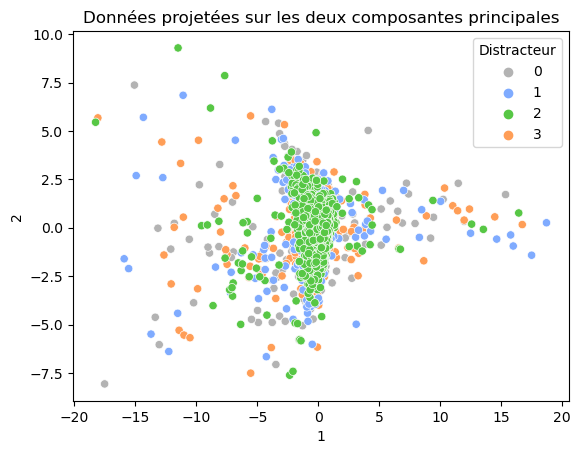

In [94]:
plt.figure()
plt.title('Données projetées sur les deux composantes principales')
sns.scatterplot(data=data_pca_tot, 
                x=1, 
                y=2,
                hue="dist_id", palette=[palette_exp['grey'], palette_exp['blue'], palette_exp['green'], palette_exp['orange']])
plt.legend(title='Distracteur')#, labels=['Aucun', 'Main droite', 'Main gauche', 'Contrôle'])
plt.show()

## Briefly evaluate models performance 
In this step, we do not tune the models but we just want to see basic performance of each algorithm that we test. 
We will train them on the train set and then use its performance on test set. 

In [95]:
df_metrics_step2 = pd.DataFrame()

In [96]:
dummy_random = DummyClassifier(strategy="uniform")
dummy_random.fit(xappr, yapp)
ypreda = dummy_random.predict(xappr)
ypredv = dummy_random.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy_random')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)

Random dummy:



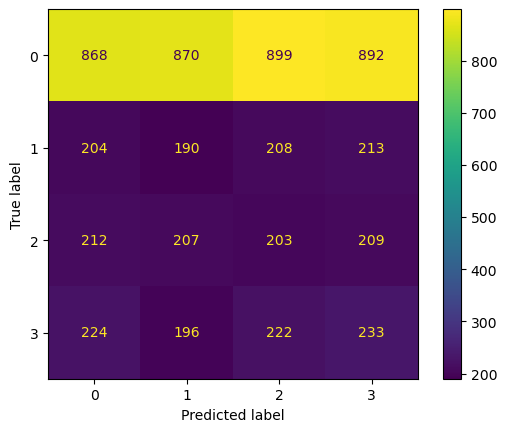

In [97]:
print('Random dummy:\n')
conf_mat(yval, ypredv, dummy_random)

Most frequent dummy:



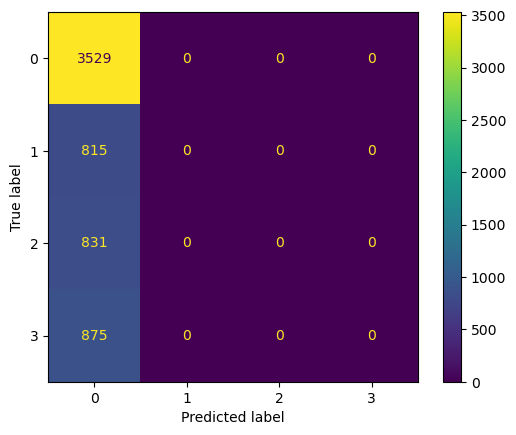

In [98]:
dummy_maj = DummyClassifier(strategy="most_frequent")
dummy_maj.fit(xappr, yapp)
ypreda = dummy_maj.predict(xappr)
ypredv = dummy_maj.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy most frequent')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
print('Most frequent dummy:\n')
conf_mat(yval, ypredv, dummy_maj)

Adaboost:



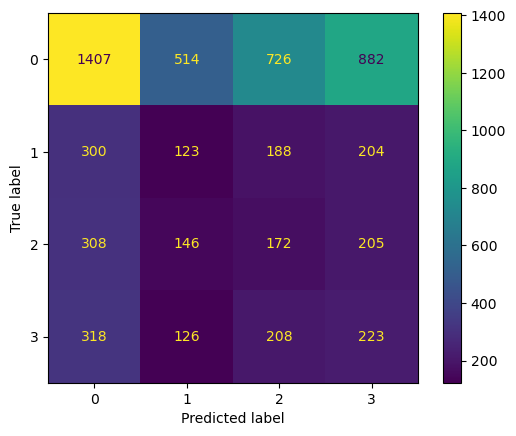

In [99]:
adaboost = AdaBoostClassifier(random_state=0).fit(xappr, yapp)
ypreda = adaboost.predict(xappr)
ypredv = adaboost.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'AdaBoostClassifier')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
print('Adaboost:\n')
conf_mat(yval, ypredv, adaboost)

ExtraTrees:



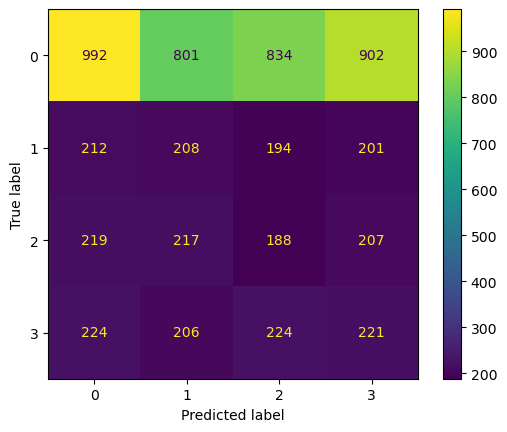

In [100]:
extratrees = ExtraTreesClassifier(random_state=0).fit(xappr, yapp)
ypreda = extratrees.predict(xappr)
ypredv = extratrees.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'ExtraTreesClassifier')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
print('ExtraTrees:\n')
conf_mat(yval, ypredv, adaboost)

RandomForest:



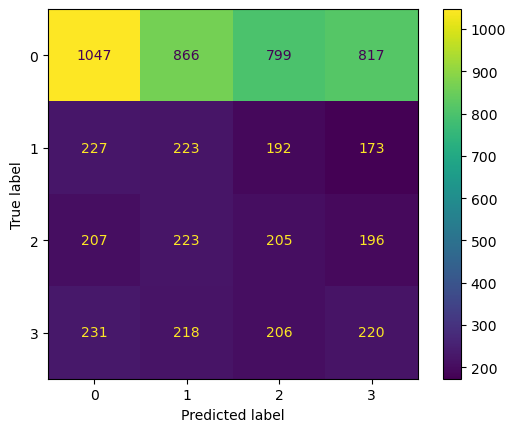

In [101]:
rf = RandomForestClassifier(random_state=0).fit(xappr, yapp)
ypreda = rf.predict(xappr)
ypredv = rf.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'RandomForectClassifier')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
print('RandomForest:\n')
conf_mat(yval, ypredv, rf)

XGBoost:



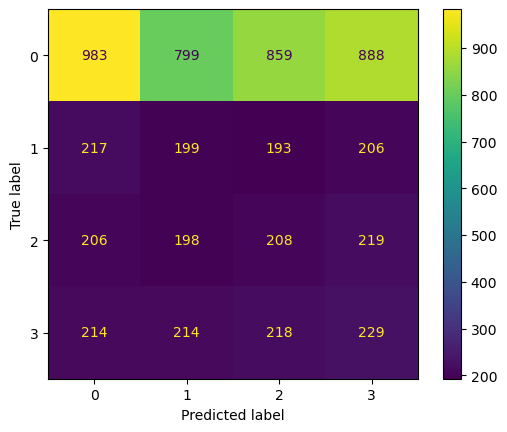

In [102]:
xg = xgb.XGBClassifier().fit(xappr, yapp)
ypreda = xg.predict(xappr)
ypredv = xg.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'XGBoostClassifier')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
print('XGBoost:\n')
conf_mat(yval, ypredv, xg)

In [103]:
df_metrics_step2.to_csv('./Iteration2/basic_clf_metrics.csv', index=False)
df_metrics_step2

,CLF Configuration,precision-train,recall-train,specificity-train,fscore-train,accuracy-train,misclassified-train,precision-val,recall-val,specificity-val,fscore-val,accuracy-val,misclassified-val
0,dummy_random,24.7718,24.7714,49.9983,24.7708,24.7714,5266.0,24.7147,24.7415,55.3867,21.8920,24.6942,4556.0
1,dummy most frequent,6.2500,25.0000,25.0000,10.0000,25.0000,5250.0,14.5826,25.0000,25.0000,18.4205,58.3306,2521.0
2,AdaBoostClassifier,31.7484,31.6571,49.0390,30.9634,31.6571,4784.0,25.4653,25.2863,53.2506,24.2826,31.8182,4125.0
3,ExtraTreesClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,25.5616,25.3780,55.0345,22.9429,26.5950,4441.0
4,RandomForectClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,26.5002,26.7106,55.0099,24.1560,28.0165,4355.0
5,XGBoostClassifier,91.5963,91.5857,49.9817,91.5854,91.5857,589.0,25.9291,25.8684,55.1023,23.2588,26.7603,4431.0


## Tune best estimator

In [104]:
scores_metrics = {}
global supmetrics
supmetrics = 0

table = adaboostclassifier("adaboostclassifier", xappr, yapp, xvalr, yval, "fscore-val") 
scores_metrics["adaboostclassifier"] = table
pk.dump(scores_metrics['adaboostclassifier'],  open('./Iteration2/adaboostclassifier.sav', 'wb'))

 ======> Running AdaBoostClassifier classifier for 10 variables
 ====== Running AdaBoostClassifier for  = {'n_estimators': 10, 'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.3}
 ======> Running adaboostclassifier ======> 

**************** Validation ****************

classification report
              precision    recall  f1-score      support
0              0.610615  0.619439  0.614995  3529.000000
1              0.140411  0.251534  0.180220   815.000000
2              0.161567  0.158845  0.160194   831.000000
3              0.248705  0.054857  0.089888   875.000000
accuracy       0.424959  0.424959  0.424959     0.424959
macro avg      0.290324  0.271169  0.261324  6050.000000
weighted avg   0.433252  0.424959  0.418012  6050.000000

confusion matrix
[[2186  827  430   86]
 [ 458  205  120   32]
 [ 460  212  132   27]
 [ 476  216  135   48]]

Precision = 29.0324 
Sensitivity = 27.1169 
Specificity = 45.659 
F-measure = 26.1324 
Accuracy = 42.4959 
misclas

In [105]:
tuned_mod = scores_metrics['adaboostclassifier'][scores_metrics['adaboostclassifier']['fscore-val'] == scores_metrics['adaboostclassifier']['fscore-val'].max()]

In [106]:
df_metrics_step2 = pd.concat([df_metrics_step2, tuned_mod], axis=0, ignore_index=False)
df_metrics_step2.to_csv('./Iteration2/basic_clf_metrics.csv', index=False)
df_metrics_step2

,CLF Configuration,precision-train,recall-train,specificity-train,fscore-train,accuracy-train,misclassified-train,precision-val,recall-val,specificity-val,fscore-val,accuracy-val,misclassified-val,indices
0,dummy_random,24.7718,24.7714,49.9983,24.7708,24.7714,5266.0,24.7147,24.7415,55.3867,21.8920,24.6942,4556.0,NaN
1,dummy most frequent,6.2500,25.0000,25.0000,10.0000,25.0000,5250.0,14.5826,25.0000,25.0000,18.4205,58.3306,2521.0,NaN
2,AdaBoostClassifier,31.7484,31.6571,49.0390,30.9634,31.6571,4784.0,25.4653,25.2863,53.2506,24.2826,31.8182,4125.0,NaN
3,ExtraTreesClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,25.5616,25.3780,55.0345,22.9429,26.5950,4441.0,NaN
4,RandomForectClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,26.5002,26.7106,55.0099,24.1560,28.0165,4355.0,NaN
5,XGBoostClassifier,91.5963,91.5857,49.9817,91.5854,91.5857,589.0,25.9291,25.8684,55.1023,23.2588,26.7603,4431.0,NaN
2,AdaBoostClassifier & hyperparams = {'n_estimat...,28.9589,28.6000,45.9051,26.0738,28.6000,4998.0,27.7967,27.4257,49.5759,26.8852,39.7025,3648.0,adaboostclassifier


## Split dataset based on subjects

In [107]:
subjects = list(data2['subj'].unique())

In [108]:
random.shuffle(subjects)

train = data2[data2['subj'].isin(subjects[:17])]  # to subject 17 represents approximatively 70% of dataset
#train.head()
test = data2[data2['subj'].isin(subjects[17:])]

In [109]:
yapp = train['dist_id']
xapp = train.drop(['subj', 'dist_id'], axis=1, inplace=False)
yval = test['dist_id']
xval = test.drop(['subj', 'dist_id'], axis=1, inplace=False)

In [110]:
# it flattens the array
yapp = np.ravel(yapp)
yval = np.ravel(yval)
# Scale numeric data 
scaler = RobustScaler().fit(xapp)
xappr = pd.DataFrame(scaler.transform(xapp))
xvalr = pd.DataFrame(scaler.transform(xval))

### Briefly evaluate models performance 
In this step, we do not tune the models but we just want to see basic performance of each algorithm that we test. 
We will train them on the train set and then use its performance on test set. 

In [111]:
df_metrics_step2 = pd.DataFrame()

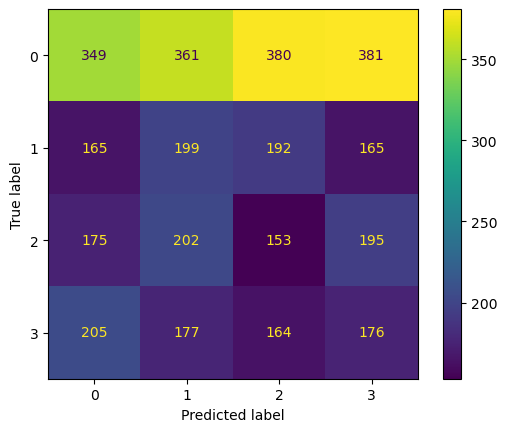

In [112]:
dummy_random = DummyClassifier(strategy="uniform")
dummy_random.fit(xappr, yapp)
ypreda = dummy_random.predict(xappr)
ypredv = dummy_random.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy_random')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
conf_mat(yval, ypredv, dummy_random)

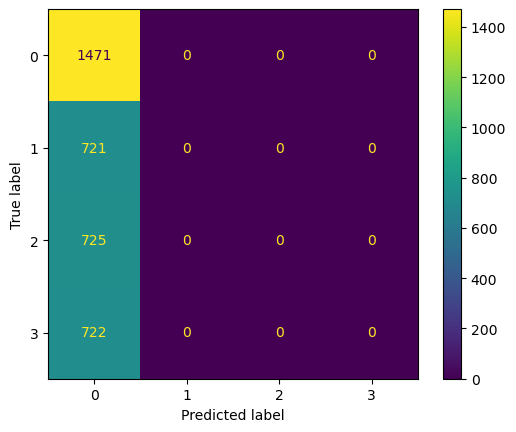

In [113]:
dummy_maj = DummyClassifier(strategy="most_frequent")
dummy_maj.fit(xappr, yapp)
ypreda = dummy_maj.predict(xappr)
ypredv = dummy_maj.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy most frequent')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
conf_mat(yval, ypredv, dummy_maj)

Adaboost:



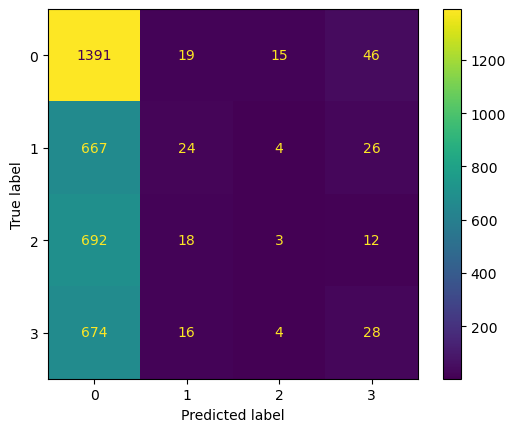

In [114]:
adaboost = AdaBoostClassifier(random_state=0).fit(xappr, yapp)
ypreda = adaboost.predict(xappr)
ypredv = adaboost.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'AdaBoostClassifier')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
print('Adaboost:\n')
conf_mat(yval, ypredv, adaboost)

ExtraTrees:



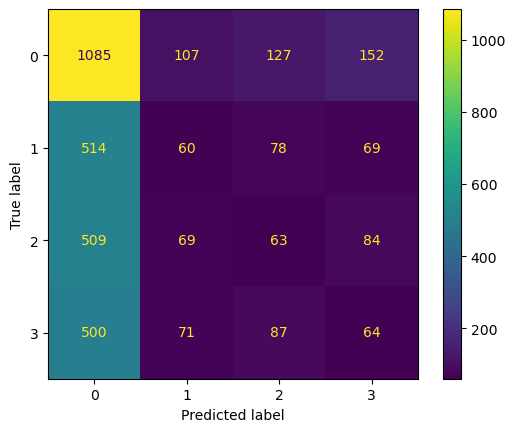

In [115]:
extratrees = ExtraTreesClassifier(random_state=0).fit(xappr, yapp)
ypreda = extratrees.predict(xappr)
ypredv = extratrees.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'ExtraTreesClassifier')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
print('ExtraTrees:\n')
conf_mat(yval, ypredv, extratrees)

RandomForest:



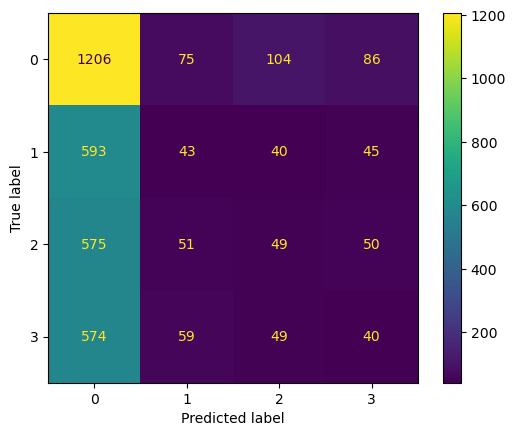

In [116]:
rf = RandomForestClassifier(random_state=0).fit(xappr, yapp)
ypreda = rf.predict(xappr)
ypredv = rf.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'RandomForectClassifier')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
print('RandomForest:\n')
conf_mat(yval, ypredv, rf)

XGBoost:



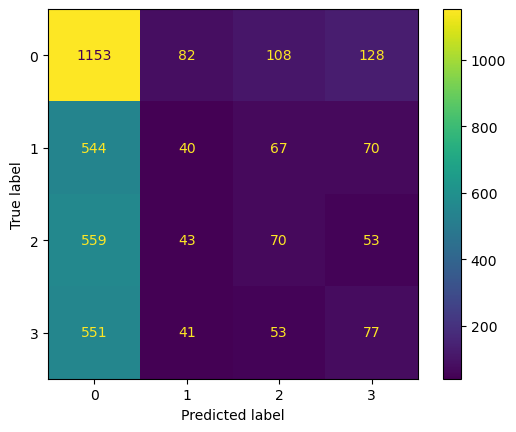

In [117]:
xg = xgb.XGBClassifier().fit(xappr, yapp)
ypreda = xg.predict(xappr)
ypredv = xg.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'XGBoostClassifier')
df_metrics_step2 = pd.concat([df_metrics_step2, sc], axis=0, ignore_index=True)
print('XGBoost:\n')
conf_mat(yval, ypredv, xg)

In [118]:
df_metrics_step2.to_csv('./Iteration2/basic_clf_metrics_SplitSubjects.csv', index=False)
df_metrics_step2

,CLF Configuration,precision-train,recall-train,specificity-train,fscore-train,accuracy-train,misclassified-train,precision-val,recall-val,specificity-val,fscore-val,accuracy-val,misclassified-val
0,dummy_random,25.8131,25.8236,51.2407,25.1596,25.9059,6973.0,24.1585,24.2015,51.2939,23.4813,24.1000,2762.0
1,dummy most frequent,10.1158,25.0000,25.0000,14.4035,40.4633,5603.0,10.1058,25.0000,25.0000,14.3933,40.4232,2168.0
2,AdaBoostClassifier,38.2405,26.4450,28.3403,18.5409,40.9733,5555.0,27.0831,25.5455,29.2912,17.5905,39.7362,2193.0
3,ExtraTreesClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,24.0593,24.9088,42.3156,22.0679,34.9547,2367.0
4,RandomForectClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,24.5291,25.0619,37.8540,20.5657,36.7683,2301.0
5,XGBoostClassifier,88.6480,73.0469,30.1000,77.7072,78.4933,2024.0,26.8647,26.0625,39.3268,22.7214,36.8233,2299.0


# STEP 3 - Feature selection  
Since we have very poor results for the classification with the very strict cutting of data in the preprocessing steps, we will start again from the whole dataset and look at univariate classification (classification based on one feature only). We will then chose 5, 7, 10, 15 better features to classify our data. 

In [301]:
df = pd.read_csv('./clean_data_oneEMG.csv')
df.head()

,dist_id,correctness,reaction_time,nb_sac,nb_sac_before_resp,amplitude_1,latency_1,duration_1,amplitude_2,latency_2,duration_2,ampli_targ,lat_targ,th_sacc_target,subj,peak_amplitude,peak_latency,onset_latency,offset_latency,burst_duration,burst_surface,burst_avg,slope,mt,burst_sum,topeak_sum,toresp_sum,ct,avg_ic,avg_cc,surface_ic,surface_cc,ic_latency,cc_latency,partial_error,partial_correct
0,0,0,846.9798,4.0,4.0,0.219146,35.0,10.0,2.843148,245.0,45.0,0.219146,35.0,1,1.0,0.002914,1.616,0.781,1.723,0.942,0.000400,0.000425,5.112471e-05,0.066,0.400589,0.325820,0.021042,0.197,NaN,0.000022,NaN,6.875027e-07,NaN,0.584,0,1
1,0,0,1089.1369,3.0,3.0,2.514761,178.0,45.0,0.617821,440.0,23.0,2.656926,546.0,3,1.0,0.001542,1.075,0.949,1.347,0.398,0.000163,0.000410,5.131321e-07,0.141,0.163223,0.017407,0.026719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3,1,1092.7854,6.0,5.0,2.566948,177.0,48.0,4.726215,377.0,60.0,4.438476,474.0,3,1.0,0.002273,1.086,1.035,1.372,0.337,0.000167,0.000495,1.726532e-04,0.058,0.166900,0.018180,0.026424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,0,1,1022.2735,2.0,2.0,3.384380,214.0,52.0,3.458086,347.0,51.0,3.458086,347.0,2,1.0,0.001190,1.006,0.917,1.332,0.415,0.000108,0.000260,7.318844e-05,0.106,0.107944,0.016898,0.024556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,1,1,1161.5520,4.0,3.0,2.047059,279.0,40.0,3.762648,407.0,50.0,3.762648,407.0,2,1.0,0.002854,1.373,1.025,1.487,0.462,0.000301,0.000651,4.787798e-05,0.138,0.300690,0.234798,0.039347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [302]:
df.drop(['subj'], inplace=True, axis=1)

In [303]:
df.shape

(13621, 35)

## Deal with missing values

In [304]:
df.isnull().sum().sort_values(ascending=False)

avg_cc                12321
surface_cc            12321
cc_latency            12321
surface_ic            11623
ic_latency            11623
avg_ic                11623
ct                    10323
latency_2              6150
duration_2             6150
amplitude_2            6150
ampli_targ             2760
lat_targ               2760
duration_1             2345
latency_1              2345
amplitude_1            2345
nb_sac_before_resp     1963
nb_sac                  323
mt                      253
toresp_sum              253
topeak_sum              253
burst_sum               253
offset_latency          253
slope                   253
burst_avg               253
burst_surface           253
burst_duration          253
onset_latency           253
peak_amplitude          253
peak_latency            253
partial_error             0
dist_id                   0
correctness               0
th_sacc_target            0
reaction_time             0
partial_correct           0
dtype: int64

In [305]:
df.isnull().sum().sort_values(ascending=False).index

Index(['avg_cc', 'surface_cc', 'cc_latency', 'surface_ic', 'ic_latency',
       'avg_ic', 'ct', 'latency_2', 'duration_2', 'amplitude_2', 'ampli_targ',
       'lat_targ', 'duration_1', 'latency_1', 'amplitude_1',
       'nb_sac_before_resp', 'nb_sac', 'mt', 'toresp_sum', 'topeak_sum',
       'burst_sum', 'offset_latency', 'slope', 'burst_avg', 'burst_surface',
       'burst_duration', 'onset_latency', 'peak_amplitude', 'peak_latency',
       'partial_error', 'dist_id', 'correctness', 'th_sacc_target',
       'reaction_time', 'partial_correct'],
      dtype='object')

Based on prior knowledge of data, I woul fill NaN values with 0 when it is related to an absence of event (for partial errors for example). However, missing values on emg features (peak amplitude...) probably is because of a noisy signal, so I would suppress these rows. 

In [306]:
event_columns = ['cc_latency', 'avg_cc', 'surface_cc', 
                 'surface_ic', 'ic_latency', 'avg_ic', 'ct', 'amplitude_2',
                 'duration_2', 'latency_2', 'ampli_targ', 'lat_targ', 'duration_1',
                 'latency_1', 'amplitude_1', 'nb_sac_before_resp', 'nb_sac']
df[event_columns] = df[event_columns].fillna(0)

In [307]:
df.isnull().sum().sort_values(ascending=False)

offset_latency        253
burst_avg             253
burst_duration        253
slope                 253
onset_latency         253
peak_latency          253
peak_amplitude        253
mt                    253
burst_sum             253
topeak_sum            253
toresp_sum            253
burst_surface         253
ct                      0
avg_ic                  0
avg_cc                  0
surface_ic              0
surface_cc              0
ic_latency              0
cc_latency              0
partial_error           0
dist_id                 0
correctness             0
th_sacc_target          0
lat_targ                0
ampli_targ              0
duration_2              0
latency_2               0
amplitude_2             0
duration_1              0
latency_1               0
amplitude_1             0
nb_sac_before_resp      0
nb_sac                  0
reaction_time           0
partial_correct         0
dtype: int64

In [308]:
noisy_columns = ['slope', 'mt', 'toresp_sum', 
                  'burst_sum', 'topeak_sum', 'burst_surface', 'burst_avg',
                 'burst_duration', 'offset_latency', 'onset_latency',
                 'peak_latency', 'peak_amplitude']

In [309]:
df = df.dropna(axis=0)
df.shape

(13368, 35)

In [310]:
df.isnull().sum()

dist_id               0
correctness           0
reaction_time         0
nb_sac                0
nb_sac_before_resp    0
amplitude_1           0
latency_1             0
duration_1            0
amplitude_2           0
latency_2             0
duration_2            0
ampli_targ            0
lat_targ              0
th_sacc_target        0
peak_amplitude        0
peak_latency          0
onset_latency         0
offset_latency        0
burst_duration        0
burst_surface         0
burst_avg             0
slope                 0
mt                    0
burst_sum             0
topeak_sum            0
toresp_sum            0
ct                    0
avg_ic                0
avg_cc                0
surface_ic            0
surface_cc            0
ic_latency            0
cc_latency            0
partial_error         0
partial_correct       0
dtype: int64

## Train-test split

In [311]:
data = df

In [312]:
target = data['dist_id']
#data.drop('dist_id', axis=1, inplace=True)

In [313]:
data.groupby(['dist_id']).count()

,correctness,reaction_time,nb_sac,nb_sac_before_resp,amplitude_1,latency_1,duration_1,amplitude_2,latency_2,duration_2,ampli_targ,lat_targ,th_sacc_target,peak_amplitude,peak_latency,onset_latency,offset_latency,burst_duration,burst_surface,burst_avg,slope,mt,burst_sum,topeak_sum,toresp_sum,ct,avg_ic,avg_cc,surface_ic,surface_cc,ic_latency,cc_latency,partial_error,partial_correct
dist_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404,5404
1,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631,2631
2,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653,2653
3,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680,2680


In [314]:
classes = target.unique() #classes
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for class_label in classes:
    # Sélection des échantillons de la classe actuelle
    class_data = data[data['dist_id'] == class_label]

    # Séparation des données de la classe en données d'entraînement et de test
    train_class_data, test_class_data = train_test_split(class_data, train_size=1850, random_state=0)  # 1850 => 0.7*2650

    # Ajout aux ensembles d'entraînement et de test globaux
    train_data = pd.concat([train_data, train_class_data], axis=0, ignore_index=True)
    test_data = pd.concat([test_data, test_class_data], axis=0, ignore_index=True)

# Réorganisation des index
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [315]:
yapp = train_data['dist_id']
xapp = train_data.drop('dist_id', axis=1, inplace=False)
yval = test_data['dist_id']
xval = test_data.drop('dist_id', axis=1, inplace=False)

In [316]:
# it flattens the array
yapp = np.ravel(yapp)
yval = np.ravel(yval)
# Scale numeric data 
scaler = RobustScaler().fit(xapp)
xappr = pd.DataFrame(scaler.transform(xapp), columns=xapp.columns)
xvalr = pd.DataFrame(scaler.transform(xval), columns=xval.columns)

In [317]:
unique, counts = np.unique(yapp, return_counts=True)
print("Training labels  : ", unique)
print("Training count  : ", counts)

Training labels  :  [0 1 2 3]
Training count  :  [1850 1850 1850 1850]


In [318]:
unique, counts = np.unique(yval, return_counts=True)
print("validation labels  : ", unique)
print("validation count  : ", counts)

validation labels  :  [0 1 2 3]
validation count  :  [3554  781  803  830]


## Visualisation of data

In [319]:
pca = PCA()
pca.fit(xappr)
data_pca = pd.DataFrame(pca.transform(xappr))

data_pca_tot = pd.concat([data_pca, pd.DataFrame(yapp, columns=['dist_id'])], axis=1)

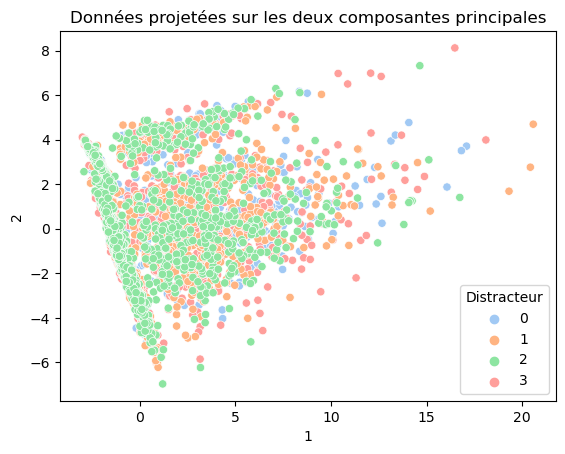

In [320]:
plt.figure()
plt.title('Données projetées sur les deux composantes principales')
sns.scatterplot(data=data_pca_tot, 
                x=1, 
                y=2,
                hue="dist_id", palette='pastel')
plt.legend(title='Distracteur')#, labels=['Aucun', 'Main droite', 'Main gauche', 'Contrôle'])
plt.show()

## Feature Selection 

In [321]:
# Train and evaluate a model for each variable

res = pd.DataFrame(columns=xappr.columns, index=['accuracy', 'precision', 'recall', 'f1score'])

for col in xappr.columns: # Assuming each sample is a list with one element
    if xappr[col].std() != 0:
        # Create and train a logistic regression model
        model = LogisticRegression(max_iter=1000, multi_class='auto')
        model.fit(np.array(xappr[col]).reshape(-1,1), yapp)

        # Make predictions
        predictions = model.predict(np.array(xvalr[col]).reshape(-1,1))

        # Evaluate the model's performance
        accuracy = accuracy_score(yval, predictions)
        precision = precision_score(yval, predictions, average='macro')
        recall = recall_score(yval, predictions, average='macro')
        f1 = f1_score(yval, predictions, average='macro')
       
        res.loc['accuracy', col] = accuracy
        res.loc['precision', col] = precision
        res.loc['recall', col] = recall
        res.loc['f1score', col] = f1
    else:
        res.loc['accuracy', col] = 0
        res.loc['precision', col] = 0
        res.loc['recall', col] = 0
        res.loc['f1score', col] = 0

    class_report = classification_report(yval, predictions)
    #print(f"Classification Report:\n{class_report}")

In [322]:
res_lda = pd.DataFrame(columns=xapp.columns, index=['accuracy', 'precision', 'recall', 'f1score'])

for col in xappr.columns: # Assuming each sample is a list with one element
    if xappr[col].std() != 0:
        # Create and train a logistic regression model
        model = LinearDiscriminantAnalysis()
        model.fit(np.array(xappr[col]).reshape(-1,1), yapp)

        # Make predictions
        predictions = model.predict(np.array(xvalr[col]).reshape(-1,1))

        # Evaluate the model's performance
        accuracy = accuracy_score(yval, predictions)
        precision = precision_score(yval, predictions, average='macro')
        recall = recall_score(yval, predictions, average='macro')
        f1 = f1_score(yval, predictions, average='macro')
       
        res_lda.loc['accuracy', col] = accuracy
        res_lda.loc['precision', col] = precision
        res_lda.loc['recall', col] = recall
        res_lda.loc['f1score', col] = f1
    else:
        res_lda.loc['accuracy', col] = 0
        res_lda.loc['precision', col] = 0
        res_lda.loc['recall', col] = 0
        res_lda.loc['f1score', col] = 0

    class_report = classification_report(yval, predictions)
    #print(f"Classification Report:\n{class_report}")

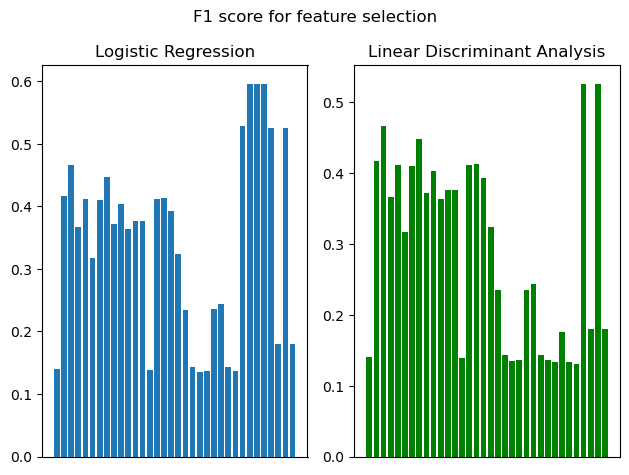

In [323]:
fig = plt.figure()
fig.add_subplot(121)
plt.bar(res.columns, res.iloc[0,:])
plt.title('Logistic Regression')
plt.xticks([])
fig.add_subplot(122)
plt.bar(res_lda.columns, res_lda.iloc[0,:], color='green')
plt.title('Linear Discriminant Analysis')
plt.suptitle('F1 score for feature selection')
plt.xticks([])
plt.tight_layout()
plt.show()

In [324]:
features = res.loc['accuracy', :].sort_values(ascending=False)

In [325]:
features.index

Index(['avg_cc', 'surface_ic', 'surface_cc', 'avg_ic', 'ic_latency',
       'partial_error', 'nb_sac', 'amplitude_2', 'reaction_time',
       'onset_latency', 'amplitude_1', 'peak_latency', 'duration_1',
       'duration_2', 'offset_latency', 'th_sacc_target', 'lat_targ',
       'latency_2', 'nb_sac_before_resp', 'ampli_targ', 'burst_duration',
       'latency_1', 'topeak_sum', 'burst_sum', 'burst_surface', 'cc_latency',
       'partial_correct', 'toresp_sum', 'burst_avg', 'correctness',
       'peak_amplitude', 'ct', 'mt', 'slope'],
      dtype='object')

## Briefly evaluate models performance with a different number of features 
In this step, we do not tune the models but we just want to see basic performance of each algorithm that we test. 
We will train them on the train set and then use its performance on test set. 

In [326]:
df_metrics_step3 = pd.DataFrame()

for nb in [5, 7, 10, 15, 20, -1]:
    xappr_red = xappr[features.index[0:nb]]
    xvalr_red = xvalr[features.index[0:nb]]

    adaboost = AdaBoostClassifier(random_state=0).fit(xappr_red, yapp)
    ypreda = adaboost.predict(xappr_red)
    ypredv = adaboost.predict(xvalr_red) 
    sc = scores(ypreda, yapp, ypredv, yval, f'AdaBoostClassifier - {nb} features')
    df_metrics_step3 = pd.concat([df_metrics_step3, sc], axis=0, ignore_index=True)
    
    extratrees = ExtraTreesClassifier(random_state=0).fit(xappr_red, yapp)
    ypreda = extratrees.predict(xappr_red)
    ypredv = extratrees.predict(xvalr_red) 
    sc = scores(ypreda, yapp, ypredv, yval, f'ExtraTreesClassifier - {nb} features')
    df_metrics_step3 = pd.concat([df_metrics_step3, sc], axis=0, ignore_index=True)

    rf = RandomForestClassifier(random_state=0).fit(xappr_red, yapp)
    ypreda = rf.predict(xappr_red)
    ypredv = rf.predict(xvalr_red) 
    sc = scores(ypreda, yapp, ypredv, yval, f'RandomForectClassifier - {nb} features')
    df_metrics_step3 = pd.concat([df_metrics_step3, sc], axis=0, ignore_index=True)
    
    xg = xgb.XGBClassifier().fit(xappr_red, yapp)
    ypreda = xg.predict(xappr_red)
    ypredv = xg.predict(xvalr_red) 
    sc = scores(ypreda, yapp, ypredv, yval, f'XGBoostClassifier - {nb} features')
    df_metrics_step3 = pd.concat([df_metrics_step3, sc], axis=0, ignore_index=True)


KeyboardInterrupt: 

In [156]:
sorted_df = df_metrics_step3.sort_values(by='fscore-val', ascending=False)
sorted_df.iloc[0]

CLF Configuration      AdaBoostClassifier - 20 features
precision-train                                 31.4765
recall-train                                    31.1081
specificity-train                                48.117
fscore-train                                    30.0743
accuracy-train                                  31.1081
misclassified-train                              5098.0
precision-val                                   27.1264
recall-val                                      27.3164
specificity-val                                 52.5933
fscore-val                                      26.6973
accuracy-val                                    37.8854
misclassified-val                                3707.0
Name: 16, dtype: object

In [327]:
print('Most informative features:\n', features.index[0:20].values)

Most informative features:
 ['avg_cc' 'surface_ic' 'surface_cc' 'avg_ic' 'ic_latency' 'partial_error'
 'nb_sac' 'amplitude_2' 'reaction_time' 'onset_latency' 'amplitude_1'
 'peak_latency' 'duration_1' 'duration_2' 'offset_latency'
 'th_sacc_target' 'lat_targ' 'latency_2' 'nb_sac_before_resp' 'ampli_targ']


## Tune best estimator

In [328]:
# Keep only those 10 features and tune adaboost model
xappr_red = xappr[features.index[0:20]]
xvalr_red = xvalr[features.index[0:20]]

In [159]:
scores_metrics = {}
global supmetrics
supmetrics = 0

table = adaboostclassifier("adaboostclassifier", xappr_red, yapp, xvalr_red, yval, "fscore-val") 
scores_metrics["adaboostclassifier"] = table
pk.dump(scores_metrics['adaboostclassifier'],  open('./Iteration3/adaboostclassifier.sav', 'wb'))

 ======> Running AdaBoostClassifier classifier for 20 variables
 ====== Running AdaBoostClassifier for  = {'n_estimators': 10, 'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.3}
 ======> Running adaboostclassifier ======> 

**************** Validation ****************

classification report
              precision    recall  f1-score      support
0              0.630689  0.577096  0.602703  3554.000000
1              0.151603  0.199744  0.172376   781.000000
2              0.144796  0.239103  0.180366   803.000000
3              0.135734  0.059036  0.082284   830.000000
accuracy       0.410188  0.410188  0.410188     0.410188
macro avg      0.265706  0.268745  0.259432  5968.000000
weighted avg   0.433780  0.410188  0.417186  5968.000000

confusion matrix
[[2051  529  767  207]
 [ 394  156  179   52]
 [ 391  167  192   53]
 [ 416  177  188   49]]

Precision = 26.5706 
Sensitivity = 26.8745 
Specificity = 49.0561 
F-measure = 25.9432 
Accuracy = 41.0188 
miscla

In [160]:
tuned_mod = scores_metrics['adaboostclassifier'][scores_metrics['adaboostclassifier']['fscore-val'] == scores_metrics['adaboostclassifier']['fscore-val'].max()]

In [161]:
df_metrics_step3 = pd.concat([df_metrics_step3, tuned_mod], axis=0, ignore_index=False)
df_metrics_step3.to_csv('./Iteration3/basic_clf_metrics.csv', index=False)
df_metrics_step3

,CLF Configuration,precision-train,recall-train,specificity-train,fscore-train,accuracy-train,misclassified-train,precision-val,recall-val,specificity-val,fscore-val,accuracy-val,misclassified-val,indices
0,AdaBoostClassifier - 5 features,32.1194,26.5270,32.5630,17.7138,26.5270,5437.0,27.4246,25.6103,37.4131,11.5625,15.2312,5059.0,NaN
1,ExtraTreesClassifier - 5 features,82.7109,43.9459,25.0000,42.0367,43.9459,4148.0,25.9396,25.3416,39.6751,12.9809,16.2701,4997.0,NaN
2,RandomForectClassifier - 5 features,78.4005,42.2703,26.2642,39.6541,42.2703,4272.0,26.1491,25.2437,39.3839,12.7406,16.2198,5000.0,NaN
3,XGBoostClassifier - 5 features,78.5675,42.5811,26.1857,40.2126,42.5811,4249.0,25.7830,25.1685,39.6219,12.9489,16.2701,4997.0,NaN
4,AdaBoostClassifier - 7 features,29.4722,27.9595,45.5636,25.2074,27.9595,5331.0,26.7628,26.2438,48.2011,25.0843,38.9745,3642.0,NaN
5,ExtraTreesClassifier - 7 features,49.3665,45.4730,46.1925,45.0901,45.4730,4035.0,26.4108,26.2013,51.8606,25.7008,36.5952,3784.0,NaN
6,RandomForectClassifier - 7 features,48.7303,44.8649,46.2008,44.4482,44.8649,4080.0,26.2619,26.0330,51.7576,25.5030,36.5617,3786.0,NaN
7,XGBoostClassifier - 7 features,54.9503,44.3378,43.9339,43.5550,44.3378,4119.0,27.0343,26.7048,49.1047,25.2837,37.1649,3750.0,NaN
8,AdaBoostClassifier - 10 features,29.9356,29.4324,46.8856,27.0853,29.4324,5222.0,25.8018,25.6500,49.1024,23.4020,33.0429,3996.0,NaN
9,ExtraTreesClassifier - 10 features,100.0000,100.0000,NaN,100.0000,100.0000,0.0,25.9562,25.5562,55.4115,22.6807,26.2399,4402.0,NaN


## Interpretability ? 

Just to test, with random forest even if worse performance than Adaboost. 

In [342]:
clf = RandomForestClassifier(random_state=0)
clf.fit(xappr,yapp)

ypreda = clf.predict(xappr)
ypredv = clf.predict(xvalr) 

In [343]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(xvalr, yval)

In [ ]:
shap.summary_plot(shap_values, xvalr)

In [ ]:
shap.summary_plot(shap_values[0], xvalr.values, feature_names=xvalr.columns)

In [ ]:
shap.summary_plot(shap_values[1], xvalr.values, feature_names=xvalr.columns)


In [ ]:

shap.summary_plot(shap_values[2], xvalr.values, feature_names=xvalr.columns)


In [ ]:
i=56
print('True label:', yval[i])
shap.force_plot(explainer.expected_value[2], shap_values[0][i], xvalr.values[i], feature_names = xvalr.columns)

# Try to train one model per subject 

In [194]:
df = pd.read_csv('./clean_data_oneEMG.csv')

In [197]:
event_columns = ['cc_latency', 'avg_cc', 'surface_cc', 
                 'surface_ic', 'ic_latency', 'avg_ic', 'ct', 'amplitude_2',
                 'duration_2', 'latency_2', 'ampli_targ', 'lat_targ', 'duration_1',
                 'latency_1', 'amplitude_1', 'nb_sac_before_resp', 'nb_sac']
df[event_columns] = df[event_columns].fillna(0)

In [198]:
noisy_columns = ['slope', 'mt', 'toresp_sum', 
                 'burst_sum', 'topeak_sum', 'burst_surface', 'burst_avg',
                 'burst_duration', 'offset_latency', 'onset_latency',
                 'peak_latency', 'peak_amplitude']

In [199]:
df = df.dropna(axis=0)
df.shape

(13368, 36)

In [201]:
df_metrics_step6 = pd.DataFrame()

In [225]:
for subject in df.subj.unique():
    data_subj = df[df.subj == subject].drop(['subj'], axis=1, inplace=False)
    x_subj = data_subj.drop(['dist_id'], axis=1, inplace=False)
    y_subj = data_subj.dist_id
    # train test split
    train_data, test_data, y_train, y_test = train_test_split(x_subj, y_subj, train_size=0.7, random_state=0, stratify=y_subj)
    
    yapp = y_train
    xapp = train_data
    yval = y_test
    xval = test_data
    
    # it flattens the array
    yapp = np.ravel(yapp)
    yval = np.ravel(yval)
    
    # Scale numeric data 
    scaler = RobustScaler().fit(xapp)
    xappr = pd.DataFrame(scaler.transform(xapp), columns=xapp.columns)
    xvalr = pd.DataFrame(scaler.transform(xval), columns=xval.columns)
    
    adaboost = AdaBoostClassifier(random_state=0).fit(xappr, yapp)
    ypreda = adaboost.predict(xappr)
    ypredv = adaboost.predict(xvalr) 
    sc = scores(ypreda, yapp, ypredv, yval, f'AdaBoostClassifier S{subject}')
    df_metrics_step6 = pd.concat([df_metrics_step6, sc], axis=0, ignore_index=True)
    
    xg = xgb.XGBClassifier().fit(xappr, yapp)
    ypreda = xg.predict(xappr)
    ypredv = xg.predict(xvalr) 
    sc = scores(ypreda, yapp, ypredv, yval, f'XGBoost S{subject}')
    df_metrics_step6 = pd.concat([df_metrics_step6, sc], axis=0, ignore_index=True)


In [228]:
#df_metrics_step6.to_csv('./Iteration5/basic_clf_metrics_modelperSubj.csv', index=False)
df_metrics_step6

,CLF Configuration,precision-train,recall-train,specificity-train,fscore-train,accuracy-train,misclassified-train,precision-val,recall-val,specificity-val,fscore-val,accuracy-val,misclassified-val
0,AdaBoostClassifier S1,63.3183,51.2964,40.0769,54.1635,59.6721,123.0,28.4532,26.6532,45.0091,26.5326,34.3511,86.0
1,XGBoost S1,100.0000,100.0000,NaN,100.0000,100.0000,0.0,32.0027,30.6849,46.4323,30.2499,40.4580,78.0
2,AdaBoostClassifier S2,53.3802,47.6119,43.9594,48.6377,53.2374,195.0,32.5162,29.1667,44.0860,28.1045,36.6667,114.0
3,XGBoost S2,100.0000,100.0000,NaN,100.0000,100.0000,0.0,27.1279,26.7361,47.3888,26.2809,32.7778,121.0
4,AdaBoostClassifier S3,56.4411,47.4639,41.9370,49.3626,53.5280,191.0,30.0365,28.9649,45.9025,28.1928,36.7232,112.0
5,XGBoost S3,100.0000,100.0000,NaN,100.0000,100.0000,0.0,31.9159,32.1443,46.2223,30.7482,40.1130,106.0
6,AdaBoostClassifier S4,51.6449,47.2980,45.8761,48.5054,52.3573,192.0,34.4498,31.2395,44.4221,31.4234,37.3563,109.0
7,XGBoost S4,100.0000,100.0000,NaN,100.0000,100.0000,0.0,27.7959,27.9622,45.3996,26.4247,36.2069,111.0
8,AdaBoostClassifier S5,48.9695,42.7082,43.6104,44.0501,48.6618,211.0,29.5861,28.8758,45.6203,27.7900,36.1582,113.0
9,XGBoost S5,100.0000,100.0000,NaN,100.0000,100.0000,0.0,21.9464,22.2345,46.5948,21.4434,28.2486,127.0


In [230]:
df_metrics_step6['fscore-val'].mean()

26.003827083333334

# STEP 4 - Neural networks 

In this step, we will try to use multi-layers perceptrons, from SKLearn and from Tensorflow, even if the number of samples is probably to low to get reliable results with TensorFlow. We will add a deeper diagnosis of these algorithms and look closely at possible overfitting. 

In [ ]:
# first test we keep all features for NN, second test we will use only 10 features since it improves performance earlier
# reuse xappr/yapp xvalr/yval and then xappr_red/xvalr_red

## Multi-layers perceptron models

In [165]:
WinpMLP = list()
#for n1 in np.arange(5,52,2):
#    WinpMLP.append(n1)  # premiere couche
for n1 in np.arange(5,16,1): # 2 couches  <------
    for n2 in np.arange(2,16,1):
        if abs(n1-n2)<=6:
            WinpMLP.append((n1, n2))  
#for n1 in np.arange(5,16,1): # 3 couches 
#    for n2 in np.arange(3,16,1):
#        for n3 in np.arange(3,11,1):
#            if abs(n1-n2)<=6 and abs(n2-n3)<=5:
#                WinpMLP.append((n1, n2, n3)) 

paramsmlp={}
m = 0
for hidden_layer in WinpMLP: 
    for alpha in [0.00001, 0.0001, 0.001]:
        for activation in ['tanh', 'relu']:
            for solver in ['adam']:
                paramsmlp[m] = {'hidden_layer_sizes':hidden_layer, 'alpha':alpha, 'activation':activation, 'solver':solver}  
                m = m + 1 
rangemlp = list(paramsmlp.keys())
def mlpclassifier(simulation, xapp, yapp, xval, yval, metrics_eval):
    global df_metrics
    df_metrics = pd.DataFrame()
    for k in rangemlp:
        params = paramsmlp[k]
        clf = None
        clf = MLPClassifier(random_state=0, early_stopping=True, max_iter=1000, learning_rate='adaptive')
        clf.set_params(**params)
        clf.fit(xapp,yapp)
        ypreda = clf.predict(xapp)
        ypredv = clf.predict(xval)
        sc = scores(ypreda, yapp, ypredv, yval, str('MLPClassifier & hyperparams = ' + str(params)))
        df_metrics = pd.concat([df_metrics, sc], axis=0, ignore_index=True)  
        global supmetrics
        if supmetrics < sc['accuracy-val'][0]:
            supmetrics = sc['accuracy-val'][0]
            print("**************** TEST ****************")
            print()
            print('classification report')
            print(pd.DataFrame(classification_report(yval, ypredv, output_dict=True)).transpose())
            print()
            print('confusion matrix')
            print(confusion_matrix(yval, ypredv))
            print()
            print('Precision = %s ' % df_metrics["precision-val"][0])
            print('F-measure = %s ' % df_metrics["fscore-val"][0])
            print('Accuracy = %s ' % df_metrics["accuracy-val"][0])
            #print('Balanced_Accuracy = %s ' % df_metrics["bacc-val"][0])
    df_metrics.insert(1, 'indices',  list(np.repeat(simulation, np.shape(df_metrics)[0], axis=0))) 
    return df_metrics

In [185]:
model_300 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(4)])

model_300.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [168]:
model_300_red = tf.keras.models.Sequential([
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(4)])

model_300_red.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [169]:
model_100_300_100_50 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(4)])

model_100_300_100_50.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [170]:
model_100_300_100_50_red = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(4)])

model_100_300_100_50_red.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [171]:
model_25_25_25_25 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(4)])

model_25_25_25_25.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),  #because running on M1 MAC
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [172]:
model_25_25_25_25_red = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(4)])

model_25_25_25_25_red.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),  #because running on M1 MAC
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [173]:
model_25_25_25_25_25_25_25 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(4)])

model_25_25_25_25_25_25_25.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [174]:
model_25_25_25_25_25_25_25_red = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(4)])

model_25_25_25_25_25_25_25_red.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [175]:
model_50_50_50_50 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(4)])

model_50_50_50_50.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),  #because running on M1 MAC
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [176]:
model_50_50_50_50_red = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(4)])

model_50_50_50_50_red.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(0.001),  #because running on M1 MAC
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.F1Score(average='macro'), 
             tf.metrics.CategoricalAccuracy()])

In [177]:
# Encode the labels to be able to use F1 score in tensorflow
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(yapp.reshape(-1, 1))
yapp_cd = encoder.transform(yapp.reshape(-1, 1))
yval_cd = encoder.transform(yval.reshape(-1, 1))

In [178]:
ep = 20

## Evaluate models performance

In [179]:
df_metrics4 = pd.DataFrame()

In [180]:
def plot_loss_evol(history):
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training','validation'])
    plt.title('Loss')
    plt.show()

In [181]:
def plot_evol_f1(history):
    fig = plt.figure()
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.legend(['training','validation'])
    plt.title('F1 score')
    plt.show()

In [182]:
scores_metrics = {}
global supmetrics
supmetrics = 0

scores_metrics["mlpclassifier"] = mlpclassifier("mlpclassifier", xappr, yapp, xvalr, yval, "fscore-val") 
pk.dump(scores_metrics["mlpclassifier"],  open('./Iteration4/mlpclassifier.sav', 'wb'))  
df_metrics4 = pd.concat([df_metrics4, scores_metrics["mlpclassifier"]], axis=0, ignore_index=True)

**************** TEST ****************

classification report
              precision    recall  f1-score      support
0              0.596016  0.420934  0.493404  3554.000000
1              0.000000  0.000000  0.000000   781.000000
2              0.135338  0.582814  0.219667   803.000000
3              0.000000  0.000000  0.000000   830.000000
accuracy       0.329088  0.329088  0.329088     0.329088
macro avg      0.182839  0.250937  0.178268  5968.000000
weighted avg   0.373143  0.329088  0.323383  5968.000000

confusion matrix
[[1496    0 2058    0]
 [ 333    0  448    0]
 [ 335    0  468    0]
 [ 346    0  484    0]]

Precision = 18.2839 
F-measure = 17.8268 
Accuracy = 32.9088 
**************** TEST ****************

classification report
              precision    recall  f1-score      support
0              0.606495  0.677828  0.640181  3554.000000
1              0.108911  0.014085  0.024943   781.000000
2              0.137493  0.296389  0.187845   803.000000
3              0.1

In [183]:
scores_metrics = {}
global supmetrics
supmetrics = 0

scores_metrics["mlpclassifier"] = mlpclassifier("mlpclassifier", xappr_red, yapp, xvalr_red, yval, "fscore-val") 
pk.dump(scores_metrics["mlpclassifier"],  open('./Iteration4/mlpclassifier_red.sav', 'wb'))  
df_metrics4 = pd.concat([df_metrics4, scores_metrics["mlpclassifier"]], axis=0, ignore_index=True)

**************** TEST ****************

classification report
              precision    recall  f1-score      support
0              0.548815  0.162915  0.251248  3554.000000
1              0.101449  0.080666  0.089872   781.000000
2              0.000000  0.000000  0.000000   803.000000
3              0.133970  0.692771  0.224522   830.000000
accuracy       0.203921  0.203921  0.203921     0.203921
macro avg      0.196059  0.234088  0.141410  5968.000000
weighted avg   0.358733  0.203921  0.192607  5968.000000

confusion matrix
[[ 579  399    0 2576]
 [ 153   63    0  565]
 [ 152   75    0  576]
 [ 171   84    0  575]]

Precision = 19.6059 
F-measure = 14.141 
Accuracy = 20.3921 
**************** TEST ****************

classification report
              precision    recall  f1-score      support
0              0.636504  0.463140  0.536156  3554.000000
1              0.139584  0.335467  0.197141   781.000000
2              0.133065  0.041096  0.062797   803.000000
3              0.13

Epoch 1/20
232/232 [==============================] - 1s 6ms/step - loss: 4.4781 - precision_9: 0.2323 - recall_9: 0.1014 - f1_score: 0.2304 - categorical_accuracy: 0.2391 - val_loss: 4.3812 - val_precision_9: 0.4873 - val_recall_9: 0.0705 - val_f1_score: 0.2162 - val_categorical_accuracy: 0.3442
Epoch 2/20
232/232 [==============================] - 0s 1ms/step - loss: 2.1682 - precision_9: 0.1941 - recall_9: 0.0169 - f1_score: 0.2265 - categorical_accuracy: 0.2339 - val_loss: 2.3071 - val_precision_9: 0.5120 - val_recall_9: 0.0179 - val_f1_score: 0.2014 - val_categorical_accuracy: 0.2349
Epoch 3/20
232/232 [==============================] - 0s 975us/step - loss: 1.5880 - precision_9: 0.2136 - recall_9: 0.0030 - f1_score: 0.2310 - categorical_accuracy: 0.2331 - val_loss: 1.3541 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.1741 - val_categorical_accuracy: 0.1734
Epoch 4/20
232/232 [==============================] - 0s 2ms/step - loss: 1.3959 - precision_9: 

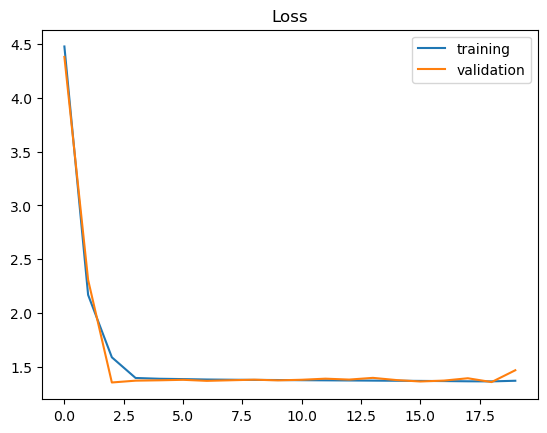

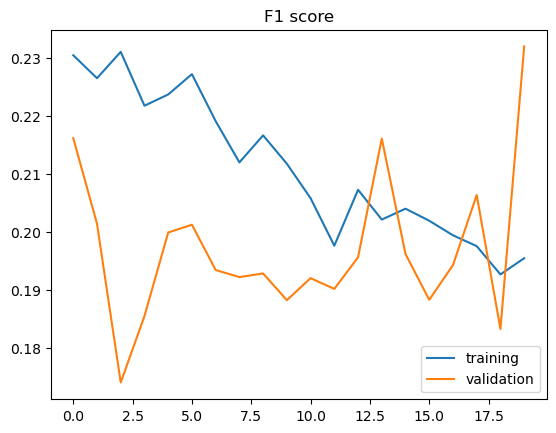

In [186]:
history_300 = model_300.fit(xappr, yapp_cd, validation_data= (xvalr, yval_cd), epochs=ep, verbose=True)
plot_loss_evol(history_300)
plot_evol_f1(history_300)

Epoch 1/20
232/232 [==============================] - 1s 4ms/step - loss: 5.0924 - precision: 0.2438 - recall: 0.1591 - f1_score: 0.2338 - categorical_accuracy: 0.2484 - val_loss: 5.1476 - val_precision: 0.1700 - val_recall: 0.1632 - val_f1_score: 0.1167 - val_categorical_accuracy: 0.1444
Epoch 2/20
232/232 [==============================] - 0s 1ms/step - loss: 4.6625 - precision: 0.2527 - recall: 0.5215 - f1_score: 0.2121 - categorical_accuracy: 0.2528 - val_loss: 3.9840 - val_precision: 0.2860 - val_recall: 0.6927 - val_f1_score: 0.1682 - val_categorical_accuracy: 0.1999
Epoch 3/20
232/232 [==============================] - 0s 885us/step - loss: 4.3775 - precision: 0.2520 - recall: 0.6470 - f1_score: 0.2196 - categorical_accuracy: 0.2562 - val_loss: 4.1498 - val_precision: 0.2826 - val_recall: 0.7270 - val_f1_score: 0.1614 - val_categorical_accuracy: 0.1764
Epoch 4/20
232/232 [==============================] - 0s 788us/step - loss: 4.3279 - precision: 0.2526 - recall: 0.6807 - f1_sco

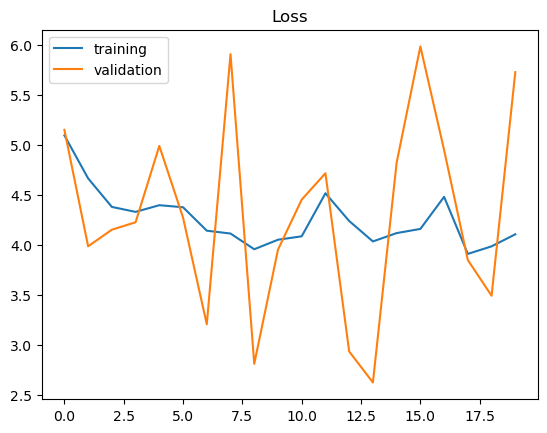

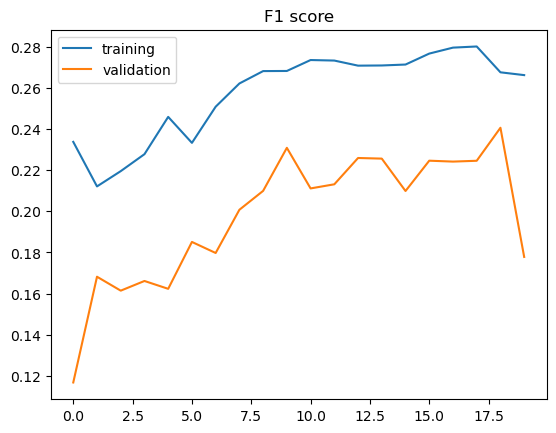

In [187]:
history_300_red = model_300_red.fit(xappr_red, yapp_cd, validation_data= (xvalr_red, yval_cd), epochs=ep, verbose=True)
plot_loss_evol(history_300_red)
plot_evol_f1(history_300_red)

Epoch 1/20
232/232 [==============================] - 2s 7ms/step - loss: 7.9641 - precision_1: 0.2496 - recall_1: 0.4920 - f1_score: 0.1551 - categorical_accuracy: 0.2482 - val_loss: 11.7672 - val_precision_1: 0.1350 - val_recall_1: 0.2699 - val_f1_score: 0.1037 - val_categorical_accuracy: 0.1346
Epoch 2/20
232/232 [==============================] - 0s 1ms/step - loss: 8.0590 - precision_1: 0.2500 - recall_1: 0.5000 - f1_score: 0.1605 - categorical_accuracy: 0.2496 - val_loss: 11.7672 - val_precision_1: 0.1350 - val_recall_1: 0.2699 - val_f1_score: 0.1037 - val_categorical_accuracy: 0.1346
Epoch 3/20
232/232 [==============================] - 0s 1ms/step - loss: 8.0590 - precision_1: 0.2500 - recall_1: 0.5000 - f1_score: 0.1605 - categorical_accuracy: 0.2496 - val_loss: 11.7672 - val_precision_1: 0.1350 - val_recall_1: 0.2699 - val_f1_score: 0.1037 - val_categorical_accuracy: 0.1346
Epoch 4/20
232/232 [==============================] - 0s 1ms/step - loss: 8.0590 - precision_1: 0.2500 

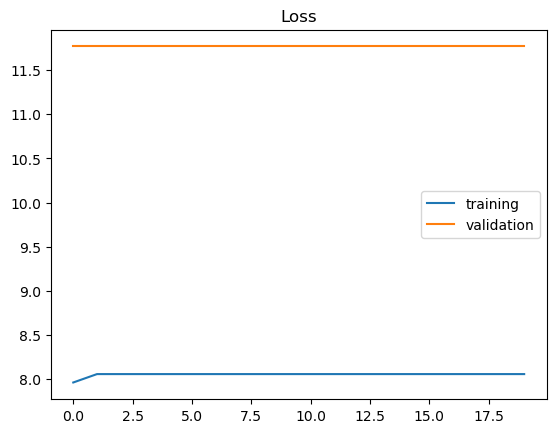

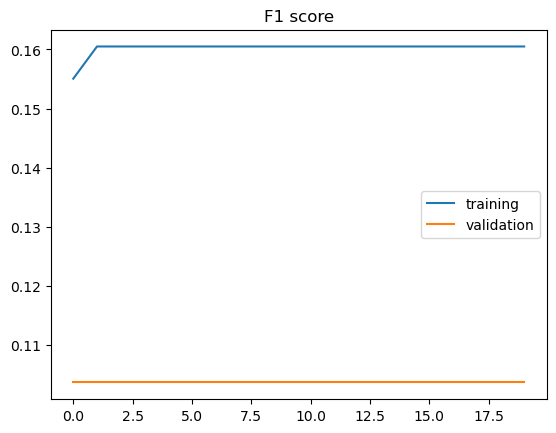

In [188]:
history_100_300_100_50 = model_100_300_100_50.fit(xapp, yapp_cd, validation_data= (xval, yval_cd), epochs=ep, verbose=True)
plot_loss_evol(history_100_300_100_50)
plot_evol_f1(history_100_300_100_50)

Epoch 1/20
232/232 [==============================] - 1s 5ms/step - loss: 7.7391 - precision_2: 0.2483 - recall_2: 0.3541 - f1_score: 0.1748 - categorical_accuracy: 0.2497 - val_loss: 5.6095 - val_precision_2: 0.3770 - val_recall_2: 0.7004 - val_f1_score: 0.2095 - val_categorical_accuracy: 0.5169
Epoch 2/20
232/232 [==============================] - 0s 1ms/step - loss: 8.0285 - precision_2: 0.2504 - recall_2: 0.4676 - f1_score: 0.1470 - categorical_accuracy: 0.2500 - val_loss: 5.6095 - val_precision_2: 0.3770 - val_recall_2: 0.7004 - val_f1_score: 0.2095 - val_categorical_accuracy: 0.5169
Epoch 3/20
232/232 [==============================] - 0s 1ms/step - loss: 8.0286 - precision_2: 0.2504 - recall_2: 0.4676 - f1_score: 0.1470 - categorical_accuracy: 0.2500 - val_loss: 5.6095 - val_precision_2: 0.3770 - val_recall_2: 0.7004 - val_f1_score: 0.2095 - val_categorical_accuracy: 0.5169
Epoch 4/20
232/232 [==============================] - 0s 1ms/step - loss: 8.0286 - precision_2: 0.2504 - r

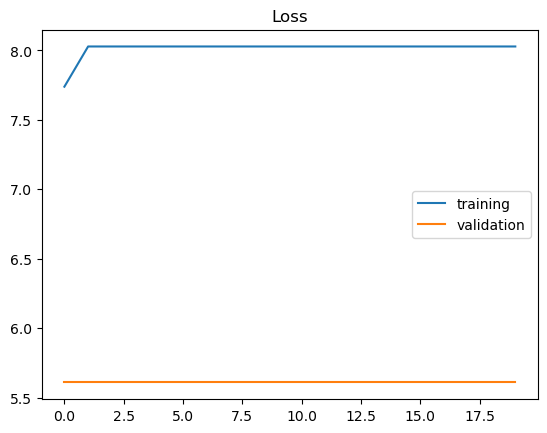

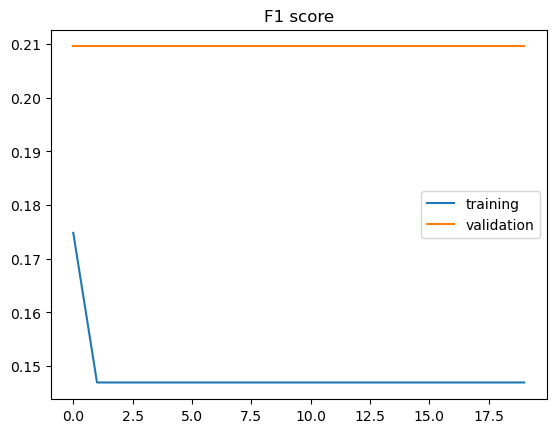

In [189]:
history_100_300_100_50_red = model_100_300_100_50_red.fit(xappr_red, yapp_cd, validation_data= (xvalr_red, yval_cd), epochs=ep, verbose=True)
plot_loss_evol(history_100_300_100_50_red)
plot_evol_f1(history_100_300_100_50_red)

Epoch 1/20
232/232 [==============================] - 2s 6ms/step - loss: 6.1003 - precision_3: 0.2507 - recall_3: 0.4069 - f1_score: 0.1827 - categorical_accuracy: 0.2428 - val_loss: 4.6132 - val_precision_3: 0.1394 - val_recall_3: 0.2017 - val_f1_score: 0.1324 - val_categorical_accuracy: 0.1287
Epoch 2/20
232/232 [==============================] - 0s 853us/step - loss: 6.4861 - precision_3: 0.2523 - recall_3: 0.3749 - f1_score: 0.1822 - categorical_accuracy: 0.2450 - val_loss: 5.4490 - val_precision_3: 0.1392 - val_recall_3: 0.2019 - val_f1_score: 0.1251 - val_categorical_accuracy: 0.1374
Epoch 3/20
232/232 [==============================] - 0s 870us/step - loss: 6.3415 - precision_3: 0.2518 - recall_3: 0.3908 - f1_score: 0.2074 - categorical_accuracy: 0.2472 - val_loss: 3.8573 - val_precision_3: 0.2803 - val_recall_3: 0.1424 - val_f1_score: 0.1200 - val_categorical_accuracy: 0.2071
Epoch 4/20
232/232 [==============================] - 0s 936us/step - loss: 1.4289 - precision_3: 0.25

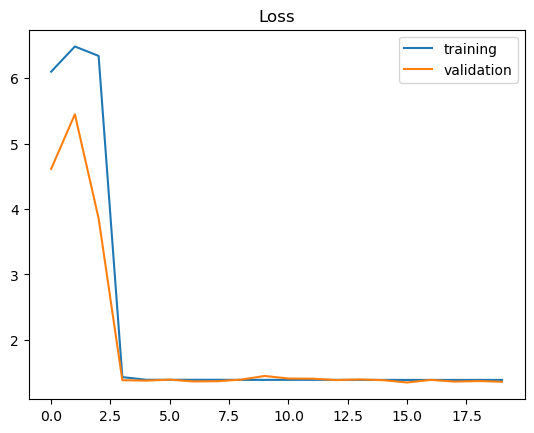

In [190]:
history_25_25_25_25 = model_25_25_25_25.fit(xapp, yapp_cd, validation_data= (xval, yval_cd), epochs=ep, verbose=True)
plot_loss_evol(history_25_25_25_25)

Epoch 1/20
232/232 [==============================] - 1s 4ms/step - loss: 6.7477 - precision_4: 0.2459 - recall_4: 0.1453 - f1_score: 0.2121 - categorical_accuracy: 0.2559 - val_loss: 10.0031 - val_precision_4: 0.3594 - val_recall_4: 0.1957 - val_f1_score: 0.2005 - val_categorical_accuracy: 0.3257
Epoch 2/20
232/232 [==============================] - 0s 887us/step - loss: 7.1828 - precision_4: 0.2631 - recall_4: 0.1476 - f1_score: 0.2166 - categorical_accuracy: 0.2591 - val_loss: 3.6222 - val_precision_4: 0.2613 - val_recall_4: 0.1768 - val_f1_score: 0.2082 - val_categorical_accuracy: 0.2951
Epoch 3/20
232/232 [==============================] - 0s 830us/step - loss: 6.2710 - precision_4: 0.2671 - recall_4: 0.2150 - f1_score: 0.2246 - categorical_accuracy: 0.2630 - val_loss: 3.5633 - val_precision_4: 0.3509 - val_recall_4: 0.3056 - val_f1_score: 0.2239 - val_categorical_accuracy: 0.3561
Epoch 4/20
232/232 [==============================] - 0s 1ms/step - loss: 6.1300 - precision_4: 0.264

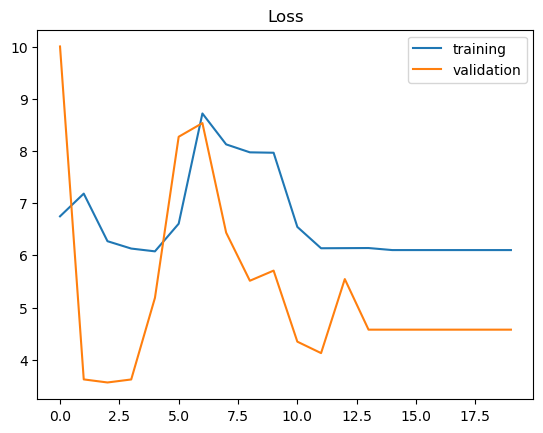

In [191]:
history_25_25_25_25_red = model_25_25_25_25_red.fit(xappr_red, yapp_cd, validation_data= (xvalr_red, yval_cd), epochs=ep, verbose=True)
plot_loss_evol(history_25_25_25_25_red)

Epoch 1/20
232/232 [==============================] - 2s 6ms/step - loss: 7.8782 - precision_5: 0.2496 - recall_5: 0.5204 - f1_score: 0.1000 - categorical_accuracy: 0.2500 - val_loss: 4.3509 - val_precision_5: 0.1350 - val_recall_5: 0.2699 - val_f1_score: 0.0579 - val_categorical_accuracy: 0.1309
Epoch 2/20
232/232 [==============================] - 0s 1ms/step - loss: 8.0590 - precision_5: 0.2500 - recall_5: 0.5000 - f1_score: 0.1000 - categorical_accuracy: 0.2500 - val_loss: 4.3509 - val_precision_5: 0.1350 - val_recall_5: 0.2699 - val_f1_score: 0.0579 - val_categorical_accuracy: 0.1309
Epoch 3/20
232/232 [==============================] - 0s 1ms/step - loss: 8.0590 - precision_5: 0.2500 - recall_5: 0.5000 - f1_score: 0.1000 - categorical_accuracy: 0.2500 - val_loss: 4.3509 - val_precision_5: 0.1350 - val_recall_5: 0.2699 - val_f1_score: 0.0579 - val_categorical_accuracy: 0.1309
Epoch 4/20
232/232 [==============================] - 0s 1ms/step - loss: 8.0590 - precision_5: 0.2500 - r

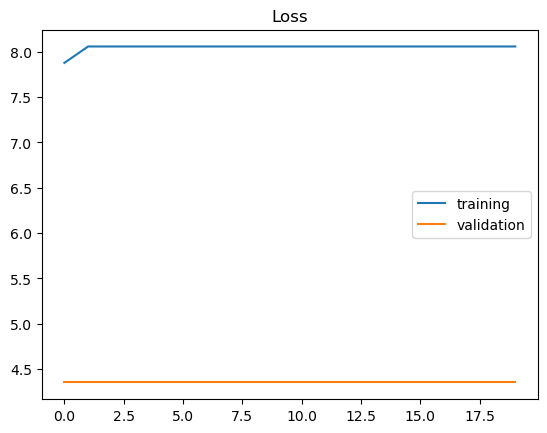

In [192]:
history_25_25_25_25_25_25_25 = model_25_25_25_25_25_25_25.fit(xapp, yapp_cd, validation_data= (xval, yval_cd), epochs=ep, verbose=True)
plot_loss_evol(history_25_25_25_25_25_25_25)

Epoch 1/20
232/232 [==============================] - 1s 5ms/step - loss: 6.9878 - precision_6: 0.2391 - recall_6: 0.0155 - f1_score: 0.1840 - categorical_accuracy: 0.2451 - val_loss: 13.8477 - val_precision_6: 0.1425 - val_recall_6: 0.0484 - val_f1_score: 0.0610 - val_categorical_accuracy: 0.1391
Epoch 2/20
232/232 [==============================] - 0s 1ms/step - loss: 12.0690 - precision_6: 0.2503 - recall_6: 0.0884 - f1_score: 0.1000 - categorical_accuracy: 0.2500 - val_loss: 13.8531 - val_precision_6: 0.1427 - val_recall_6: 0.0488 - val_f1_score: 0.0610 - val_categorical_accuracy: 0.1391
Epoch 3/20
232/232 [==============================] - 0s 1ms/step - loss: 12.0690 - precision_6: 0.2503 - recall_6: 0.0884 - f1_score: 0.1000 - categorical_accuracy: 0.2500 - val_loss: 13.8531 - val_precision_6: 0.1427 - val_recall_6: 0.0488 - val_f1_score: 0.0610 - val_categorical_accuracy: 0.1391
Epoch 4/20
232/232 [==============================] - 0s 1ms/step - loss: 12.0690 - precision_6: 0.25

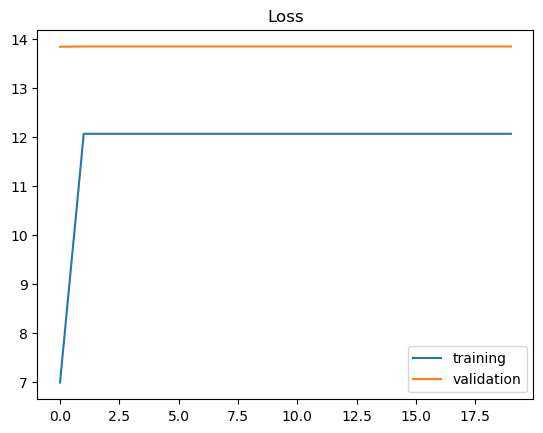

In [193]:
history_25_25_25_25_25_25_25_red = model_25_25_25_25_25_25_25_red.fit(xappr_red, yapp_cd, validation_data= (xvalr_red, yval_cd), epochs=ep, verbose=True)
plot_loss_evol(history_25_25_25_25_25_25_25_red)

# Distinction between trial types without no distractor trials

In [231]:
df = pd.read_csv('./clean_data_oneEMG.csv')
df = df[df.dist_id != 0]  # 3 classes only and balanced

In [233]:
event_columns = ['cc_latency', 'avg_cc', 'surface_cc',
                 'surface_ic', 'ic_latency', 'avg_ic', 'ct', 'amplitude_2',
                 'duration_2', 'latency_2', 'ampli_targ', 'lat_targ', 'duration_1',
                 'latency_1', 'amplitude_1', 'nb_sac_before_resp', 'nb_sac']
df[event_columns] = df[event_columns].fillna(0)

In [234]:
noisy_columns = ['slope', 'mt', 'toresp_sum', 
                 'burst_sum', 'topeak_sum', 'burst_surface', 'burst_avg',
                 'burst_duration', 'offset_latency', 'onset_latency',
                 'peak_latency', 'peak_amplitude']

In [235]:
df = df.dropna(axis=0)
df.shape

(7964, 36)

In [236]:
data = df.drop(['subj'], axis=1, inplace=False)

In [237]:
target = data['dist_id']
data.drop('dist_id', axis=1, inplace=True)

In [238]:
data.shape

(7964, 34)

In [239]:
train_data, test_data, y_train, y_test = train_test_split(data, target, test_size=0.3)

In [240]:
y_train.value_counts()

dist_id
3    1872
2    1853
1    1849
Name: count, dtype: int64

In [241]:
y_test.value_counts()

dist_id
3    808
2    800
1    782
Name: count, dtype: int64

In [242]:
yapp = y_train
xapp = train_data
yval = y_test
xval = test_data

In [243]:
# it flattens the array
yapp = np.ravel(yapp)
yval = np.ravel(yval)
# Scale numeric data 
scaler = RobustScaler().fit(xapp)
xappr = pd.DataFrame(scaler.transform(xapp), columns=xapp.columns)
xvalr = pd.DataFrame(scaler.transform(xval), columns=xval.columns)

In [244]:
unique, counts = np.unique(yapp, return_counts=True)
print("Testing labels  : ", unique)
print("Testing count  : ", counts)

Testing labels  :  [1 2 3]
Testing count  :  [1849 1853 1872]


In [245]:
unique, counts = np.unique(yval, return_counts=True)
print("Testing labels  : ", unique)
print("Testing count  : ", counts)

Testing labels  :  [1 2 3]
Testing count  :  [782 800 808]


## Visualisation

In [246]:
pca = PCA()
pca.fit(xappr)
data_pca = pd.DataFrame(pca.transform(xappr))

data_pca_tot = pd.concat([data_pca, pd.DataFrame(yapp, columns=['dist_id'])], axis=1)

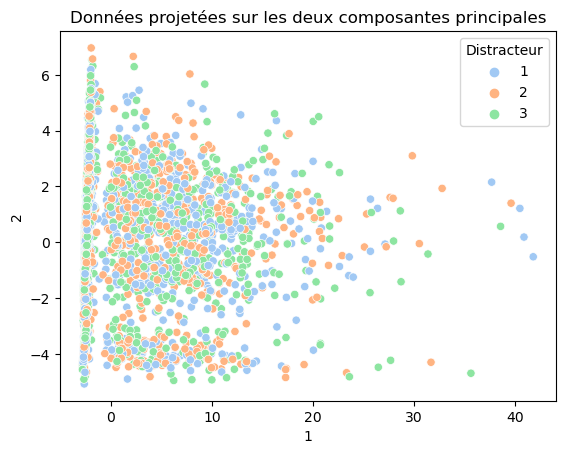

In [247]:
plt.figure()
plt.title('Données projetées sur les deux composantes principales')
sns.scatterplot(data=data_pca_tot, 
                x=1, 
                y=2,
                hue="dist_id", palette='pastel')
plt.legend(title='Distracteur')#, labels=['Aucun', 'Main droite', 'Main gauche', 'Contrôle'])
plt.show()

## Evaluate models performance

In [248]:
df_metrics_step5 = pd.DataFrame()

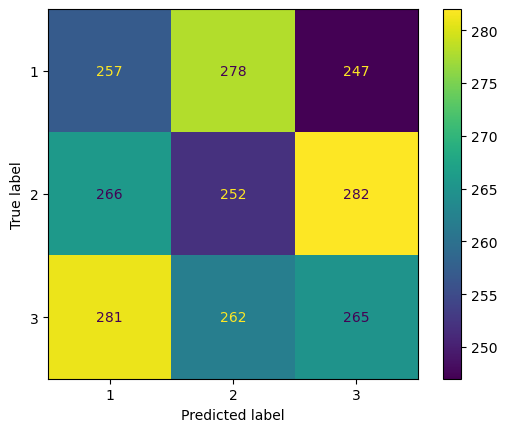

In [249]:
dummy_random = DummyClassifier(strategy="uniform")
dummy_random.fit(xappr, yapp)
ypreda = dummy_random.predict(xappr)
ypredv = dummy_random.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy_random')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
conf_mat(yval, ypredv, dummy_random)

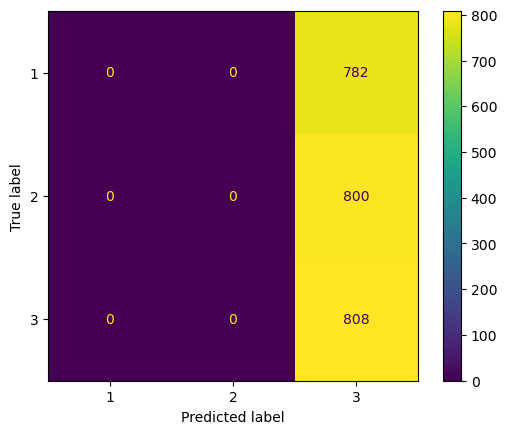

In [250]:
dummy_maj = DummyClassifier(strategy="most_frequent")
dummy_maj.fit(xappr, yapp)
ypreda = dummy_maj.predict(xappr)
ypredv = dummy_maj.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy most frequent')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
conf_mat(yval, ypredv, dummy_maj)

Adaboost:



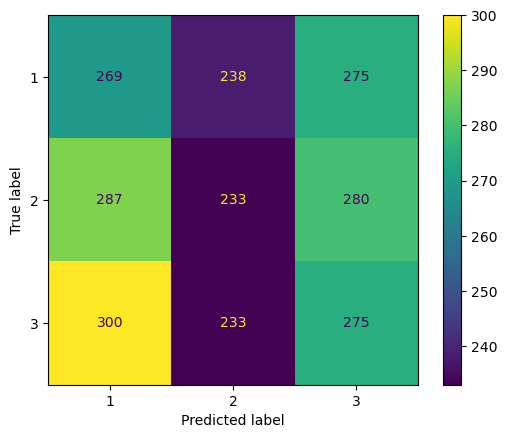

In [251]:
adaboost = AdaBoostClassifier(random_state=0).fit(xappr, yapp)
ypreda = adaboost.predict(xappr)
ypredv = adaboost.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'AdaBoostClassifier')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
print('Adaboost:\n')
conf_mat(yval, ypredv, adaboost)


ExtraTrees:



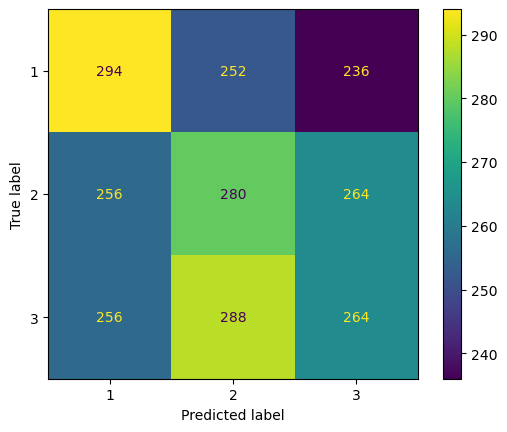

In [252]:
extratrees = ExtraTreesClassifier(random_state=0).fit(xappr, yapp)
ypreda = extratrees.predict(xappr)
ypredv = extratrees.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'ExtraTreesClassifier')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
print('ExtraTrees:\n')
conf_mat(yval, ypredv, extratrees)

RandomForest:



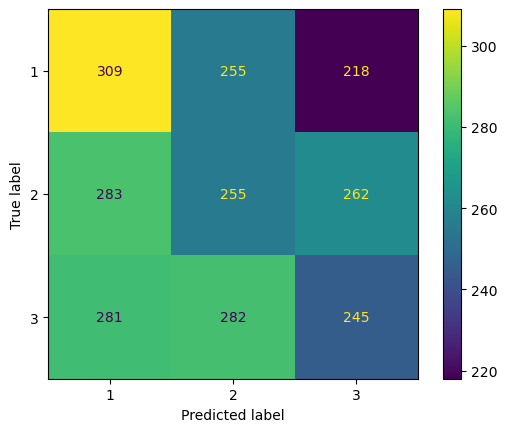

In [253]:
rf = RandomForestClassifier(random_state=0).fit(xappr, yapp)
ypreda = rf.predict(xappr)
ypredv = rf.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'RandomForectClassifier')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
print('RandomForest:\n')
conf_mat(yval, ypredv, rf)

In [254]:
yapp_xg = pd.DataFrame(yapp)
yapp_xg = np.ravel(yapp_xg - 1)
yval_xg = pd.DataFrame(yval)
yval_xg = np.ravel(yval_xg - 1)

XGBoost:



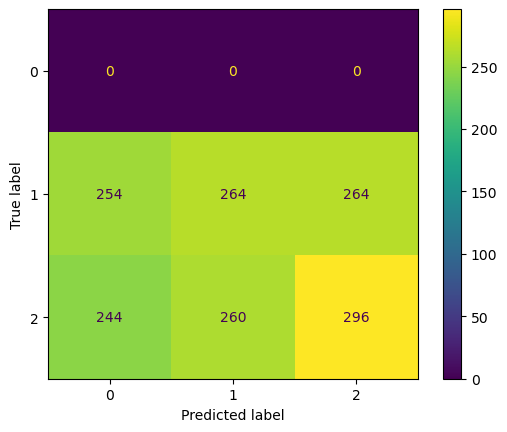

In [255]:
xg = xgb.XGBClassifier().fit(xappr, yapp_xg)
ypreda = xg.predict(xappr)
ypredv = xg.predict(xvalr) 
sc = scores(ypreda, yapp_xg, ypredv, yval_xg, 'XGBoost')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
print('XGBoost:\n')
conf_mat(yval, ypredv, xg)

In [256]:
df_metrics_step5.to_csv('./Iteration5/basic_clf_metrics_3classes.csv', index=False)
df_metrics_step5

,CLF Configuration,precision-train,recall-train,specificity-train,fscore-train,accuracy-train,misclassified-train,precision-val,recall-val,specificity-val,fscore-val,accuracy-val,misclassified-val
0,dummy_random,33.5964,33.5982,49.9947,33.5928,33.6024,3701.0,32.3862,32.3872,50.0018,32.3835,32.3849,1616.0
1,dummy most frequent,11.1948,33.3333,33.3333,16.7607,33.5845,3702.0,11.2692,33.3333,33.3333,16.8439,33.8075,1582.0
2,AdaBoostClassifier,40.3309,40.4094,50.0000,40.2956,40.4198,3321.0,32.5515,32.5195,49.9168,32.4688,32.5105,1613.0
3,ExtraTreesClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,35.0592,35.0897,50.0120,35.0611,35.0628,1552.0
4,RandomForectClassifier,100.0000,100.0000,NaN,100.0000,100.0000,0.0,33.7951,33.9036,50.0130,33.7800,33.8494,1581.0
5,XGBoost,98.1332,98.1338,49.9607,98.1334,98.1342,104.0,32.7702,32.7576,49.9869,32.7595,32.7615,1607.0


Overfitting.

# Try to train one model per subject 

In [194]:
df = pd.read_csv('./clean_data_oneEMG.csv')

In [197]:
event_columns = ['cc_latency', 'avg_cc', 'surface_cc', 
                 'surface_ic', 'ic_latency', 'avg_ic', 'ct', 'amplitude_2',
                 'duration_2', 'latency_2', 'ampli_targ', 'lat_targ', 'duration_1',
                 'latency_1', 'amplitude_1', 'nb_sac_before_resp', 'nb_sac']
df[event_columns] = df[event_columns].fillna(0)

In [198]:
noisy_columns = ['slope', 'mt', 'toresp_sum', 
                 'burst_sum', 'topeak_sum', 'burst_surface', 'burst_avg',
                 'burst_duration', 'offset_latency', 'onset_latency',
                 'peak_latency', 'peak_amplitude']

In [199]:
df = df.dropna(axis=0)
df.shape

(13368, 36)

In [201]:
df_metrics_step6 = pd.DataFrame()

In [225]:
for subject in df.subj.unique():
    data_subj = df[df.subj == subject].drop(['subj'], axis=1, inplace=False)
    x_subj = data_subj.drop(['dist_id'], axis=1, inplace=False)
    y_subj = data_subj.dist_id
    # train test split
    train_data, test_data, y_train, y_test = train_test_split(x_subj, y_subj, train_size=0.7, random_state=0, stratify=y_subj)
    
    yapp = y_train
    xapp = train_data
    yval = y_test
    xval = test_data
    
    # it flattens the array
    yapp = np.ravel(yapp)
    yval = np.ravel(yval)
    
    # Scale numeric data 
    scaler = RobustScaler().fit(xapp)
    xappr = pd.DataFrame(scaler.transform(xapp), columns=xapp.columns)
    xvalr = pd.DataFrame(scaler.transform(xval), columns=xval.columns)
    
    adaboost = AdaBoostClassifier(random_state=0).fit(xappr, yapp)
    ypreda = adaboost.predict(xappr)
    ypredv = adaboost.predict(xvalr) 
    sc = scores(ypreda, yapp, ypredv, yval, f'AdaBoostClassifier S{subject}')
    df_metrics_step6 = pd.concat([df_metrics_step6, sc], axis=0, ignore_index=True)
    
    xg = xgb.XGBClassifier().fit(xappr, yapp)
    ypreda = xg.predict(xappr)
    ypredv = xg.predict(xvalr) 
    sc = scores(ypreda, yapp, ypredv, yval, f'XGBoost S{subject}')
    df_metrics_step6 = pd.concat([df_metrics_step6, sc], axis=0, ignore_index=True)


In [228]:
#df_metrics_step6.to_csv('./Iteration5/basic_clf_metrics_modelperSubj.csv', index=False)
df_metrics_step6

,CLF Configuration,precision-train,recall-train,specificity-train,fscore-train,accuracy-train,misclassified-train,precision-val,recall-val,specificity-val,fscore-val,accuracy-val,misclassified-val
0,AdaBoostClassifier S1,63.3183,51.2964,40.0769,54.1635,59.6721,123.0,28.4532,26.6532,45.0091,26.5326,34.3511,86.0
1,XGBoost S1,100.0000,100.0000,NaN,100.0000,100.0000,0.0,32.0027,30.6849,46.4323,30.2499,40.4580,78.0
2,AdaBoostClassifier S2,53.3802,47.6119,43.9594,48.6377,53.2374,195.0,32.5162,29.1667,44.0860,28.1045,36.6667,114.0
3,XGBoost S2,100.0000,100.0000,NaN,100.0000,100.0000,0.0,27.1279,26.7361,47.3888,26.2809,32.7778,121.0
4,AdaBoostClassifier S3,56.4411,47.4639,41.9370,49.3626,53.5280,191.0,30.0365,28.9649,45.9025,28.1928,36.7232,112.0
5,XGBoost S3,100.0000,100.0000,NaN,100.0000,100.0000,0.0,31.9159,32.1443,46.2223,30.7482,40.1130,106.0
6,AdaBoostClassifier S4,51.6449,47.2980,45.8761,48.5054,52.3573,192.0,34.4498,31.2395,44.4221,31.4234,37.3563,109.0
7,XGBoost S4,100.0000,100.0000,NaN,100.0000,100.0000,0.0,27.7959,27.9622,45.3996,26.4247,36.2069,111.0
8,AdaBoostClassifier S5,48.9695,42.7082,43.6104,44.0501,48.6618,211.0,29.5861,28.8758,45.6203,27.7900,36.1582,113.0
9,XGBoost S5,100.0000,100.0000,NaN,100.0000,100.0000,0.0,21.9464,22.2345,46.5948,21.4434,28.2486,127.0


# Detection of one distractor, no matter its type

In [257]:
df = pd.read_csv('./clean_data_oneEMG.csv')

target = df['dist_id']
target [target > 0] = 1
df['dist_id'] = target

In [259]:
event_columns = ['cc_latency', 'avg_cc', 'surface_cc',
                 'surface_ic', 'ic_latency', 'avg_ic', 'ct', 'amplitude_2',
                 'duration_2', 'latency_2', 'ampli_targ', 'lat_targ', 'duration_1',
                 'latency_1', 'amplitude_1', 'nb_sac_before_resp', 'nb_sac']
df[event_columns] = df[event_columns].fillna(0)

In [260]:
noisy_columns = ['slope', 'mt', 'toresp_sum', 
                 'burst_sum', 'topeak_sum', 'burst_surface', 'burst_avg',
                 'burst_duration', 'offset_latency', 'onset_latency',
                 'peak_latency', 'peak_amplitude']

In [261]:
df = df.dropna(axis=0)
df.shape

(13368, 36)

In [262]:
data = df.drop(['subj'], axis=1, inplace=False)

In [263]:
target = data['dist_id']
data.drop('dist_id', axis=1, inplace=True)

In [264]:
data.shape

(13368, 34)

In [265]:
train_data, test_data, y_train, y_test = train_test_split(data, target, test_size=0.3)

In [266]:
y_train.value_counts()

dist_id
1    5519
0    3838
Name: count, dtype: int64

In [267]:
y_test.value_counts()

dist_id
1    2445
0    1566
Name: count, dtype: int64

In [268]:
yapp = y_train
xapp = train_data
yval = y_test
xval = test_data

In [269]:
# it flattens the array
yapp = np.ravel(yapp)
yval = np.ravel(yval)
# Scale numeric data 
scaler = RobustScaler().fit(xapp)
xappr = pd.DataFrame(scaler.transform(xapp), columns=xapp.columns)
xvalr = pd.DataFrame(scaler.transform(xval), columns=xval.columns)

In [270]:
unique, counts = np.unique(yapp, return_counts=True)
print("Testing labels  : ", unique)
print("Testing count  : ", counts)

Testing labels  :  [0 1]
Testing count  :  [3838 5519]


In [271]:
unique, counts = np.unique(yval, return_counts=True)
print("Testing labels  : ", unique)
print("Testing count  : ", counts)

Testing labels  :  [0 1]
Testing count  :  [1566 2445]


## Visualisation

In [272]:
pca = PCA()
pca.fit(xappr)
data_pca = pd.DataFrame(pca.transform(xappr))

data_pca_tot = pd.concat([data_pca, pd.DataFrame(yapp, columns=['dist_id'])], axis=1)

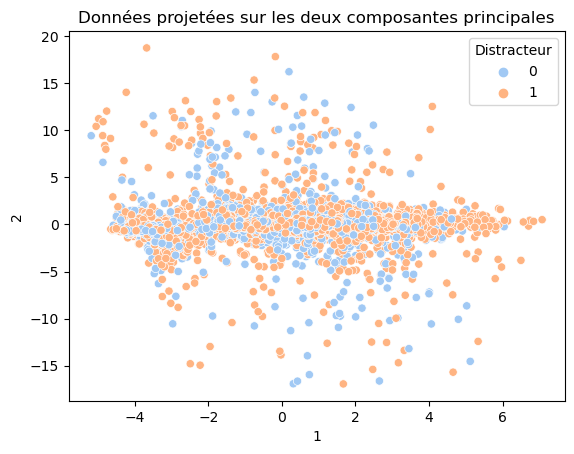

In [273]:
plt.figure()
plt.title('Données projetées sur les deux composantes principales')
sns.scatterplot(data=data_pca_tot, 
                x=1, 
                y=2,
                hue="dist_id", palette='pastel')
plt.legend(title='Distracteur')#, labels=['Aucun', 'Main droite', 'Main gauche', 'Contrôle'])
plt.show()

## Evaluate models performance

In [290]:
df_metrics_step5 = pd.DataFrame()

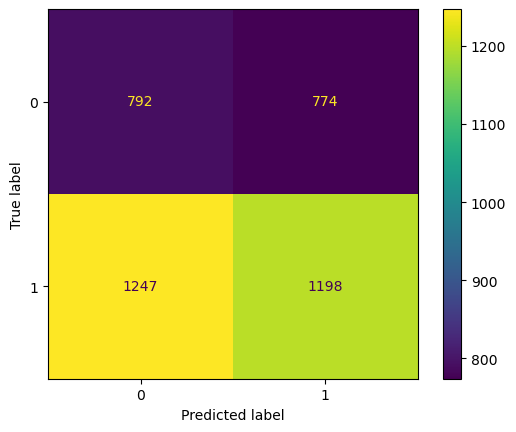

In [291]:
dummy_random = DummyClassifier(strategy="uniform")
dummy_random.fit(xappr, yapp)
ypreda = dummy_random.predict(xappr)
ypredv = dummy_random.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy_random')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
conf_mat(yval, ypredv, dummy_random)

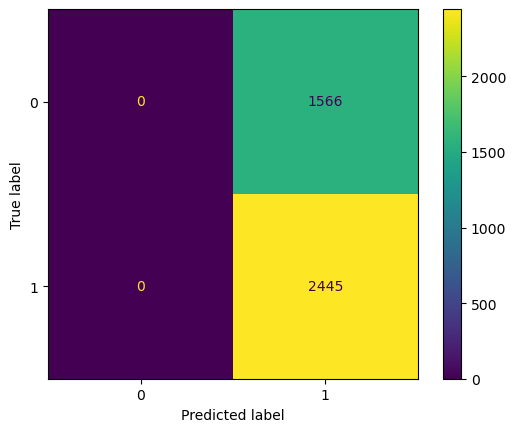

In [292]:
dummy_maj = DummyClassifier(strategy="most_frequent")
dummy_maj.fit(xappr, yapp)
ypreda = dummy_maj.predict(xappr)
ypredv = dummy_maj.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'dummy most frequent')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
conf_mat(yval, ypredv, dummy_maj)

Adaboost:



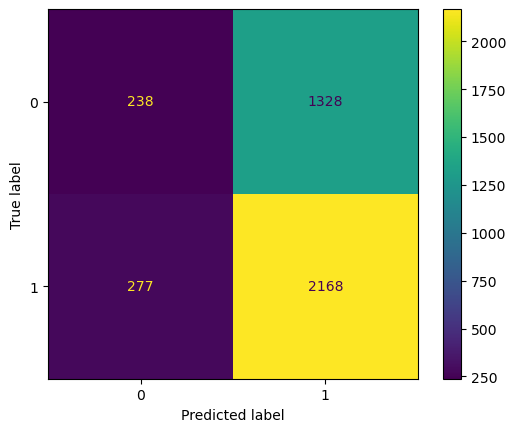

In [293]:
adaboost = AdaBoostClassifier(random_state=0).fit(xappr, yapp)
ypreda = adaboost.predict(xappr)
ypredv = adaboost.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'AdaBoostClassifier')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
print('Adaboost:\n')
conf_mat(yval, ypredv, adaboost)

ExtraTrees:



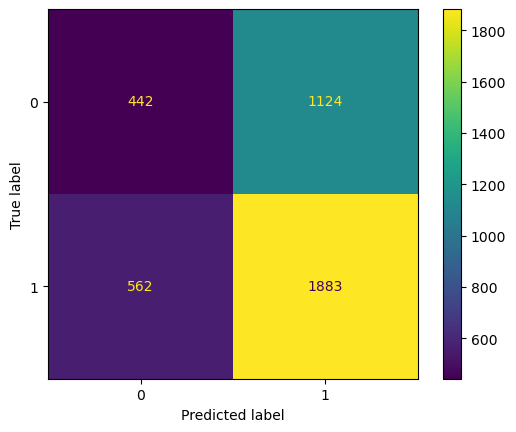

In [294]:
extratrees = ExtraTreesClassifier(random_state=0).fit(xappr, yapp)
ypreda = extratrees.predict(xappr)
ypredv = extratrees.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'ExtraTreesClassifier')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
print('ExtraTrees:\n')
conf_mat(yval, ypredv, extratrees)

RandomForest:



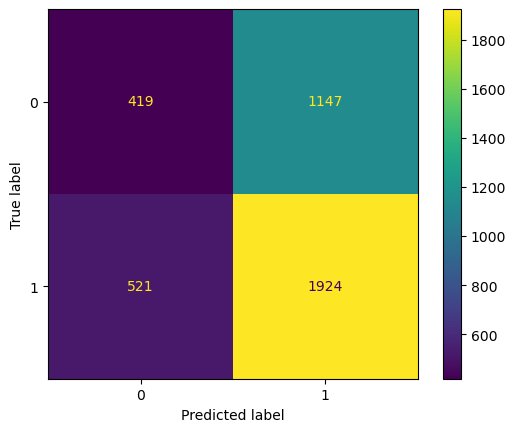

In [295]:
rf = RandomForestClassifier(random_state=0).fit(xappr, yapp)
ypreda = rf.predict(xappr)
ypredv = rf.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'RandomForectClassifier')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
print('RandomForest:\n')
conf_mat(yval, ypredv, rf)

XGBoost:



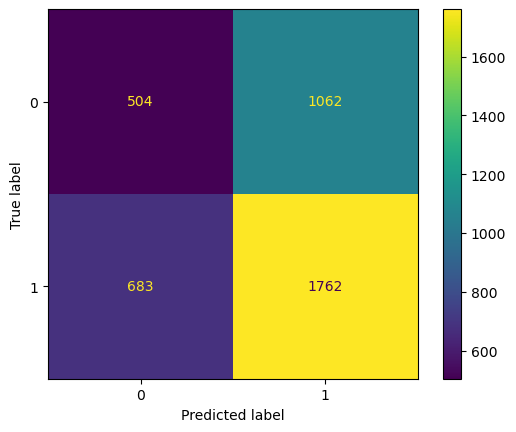

In [296]:
xg = xgb.XGBClassifier().fit(xappr, yapp)
ypreda = xg.predict(xappr)
ypredv = xg.predict(xvalr) 
sc = scores(ypreda, yapp, ypredv, yval, 'XGBoost')
df_metrics_step5 = pd.concat([df_metrics_step5, sc], axis=0, ignore_index=True)
print('XGBoost:\n')
conf_mat(yval, ypredv, xg)

In [297]:
df_metrics_step5.to_csv('./Iteration5/basic_clf_metrics_2classes.csv', index=False)
df_metrics_step5

,CLF Configuration,precision-train,recall-train,specificity-train,fscore-train,accuracy-train,misclassified-train,precision-val,recall-val,specificity-val,fscore-val,accuracy-val,misclassified-val
0,dummy_random,58.7640,49.4474,50.1042,53.7046,49.7168,4705.0,60.7505,48.9980,50.5747,54.2450,49.6136,2021.0
1,dummy most frequent,58.9826,100.0000,0.0000,74.2001,58.9826,3838.0,60.9574,100.0000,0.0000,75.7435,60.9574,1566.0
2,AdaBoostClassifier,61.4128,89.9438,18.7337,72.9893,60.7353,3674.0,62.0137,88.6708,15.1980,72.9843,59.9850,1605.0
3,ExtraTreesClassifier,100.0000,100.0000,100.0000,100.0000,100.0000,0.0,62.6206,77.0143,28.2248,69.0756,57.9656,1686.0
4,RandomForectClassifier,100.0000,100.0000,100.0000,100.0000,100.0000,0.0,62.6506,78.6912,26.7561,69.7607,58.4144,1668.0
5,XGBoost,91.0160,98.2062,86.0604,94.4745,93.2243,634.0,62.3938,72.0654,32.1839,66.8818,56.4946,1745.0


In [298]:
scores_metrics = {}
global supmetrics
supmetrics = 0

table = adaboostclassifier("adaboostclassifier", xappr, yapp, xvalr, yval, "fscore-val") 
scores_metrics["adaboostclassifier"] = table
pk.dump(scores_metrics['adaboostclassifier'],  open('./Iteration5/adaboostclassifier_2classes.sav', 'wb'))

 ======> Running AdaBoostClassifier classifier for 34 variables
 ====== Running AdaBoostClassifier for  = {'n_estimators': 10, 'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.3}
 ======> Running adaboostclassifier ======> 

**************** Validation ****************

classification report
              precision    recall  f1-score      support
0              0.000000  0.000000  0.000000  1566.000000
1              0.609574  1.000000  0.757435  2445.000000
accuracy       0.609574  0.609574  0.609574     0.609574
macro avg      0.304787  0.500000  0.378717  4011.000000
weighted avg   0.371580  0.609574  0.461712  4011.000000

confusion matrix
[[   0 1566]
 [   0 2445]]

Precision = 60.9574 
Sensitivity = 100.0 
Specificity = 0.0 
F-measure = 75.7435 
Accuracy = 60.9574 
misclassification = 1566.0 

 ======> Running AdaBoostClassifier classifier for 34 variables
 ====== Running AdaBoostClassifier for  = {'n_estimators': 16, 'base_estimator': DecisionTreeClassi

KeyboardInterrupt: 

In [ ]:
tuned_mod = scores_metrics['adaboostclassifier'][scores_metrics['adaboostclassifier']['fscore-val'] == scores_metrics['adaboostclassifier']['fscore-val'].max()]

In [ ]:
df_metrics_step5 = pd.concat([df_metrics_step5, tuned_mod], axis=0, ignore_index=False)
df_metrics_step5.to_csv('./Iteration5/basic_clf_metrics_2classes.csv', index=False)
df_metrics_step5

## One model per subject

In [ ]:
df_metrics_step6 = pd.DataFrame()

In [ ]:
for subject in df.subj.unique():
    data_subj = df[df.subj == subject].drop(['subj'], axis=1, inplace=False)
    x_subj = data_subj.drop(['dist_id'], axis=1, inplace=False)
    y_subj = data_subj.dist_id
    # train test split
    train_data, test_data, y_train, y_test = train_test_split(x_subj, y_subj, train_size=0.7, random_state=0, stratify=y_subj)
    
    yapp = y_train
    xapp = train_data
    yval = y_test
    xval = test_data
    
    # it flattens the array
    yapp = np.ravel(yapp)
    yval = np.ravel(yval)
    
    # Scale numeric data 
    scaler = RobustScaler().fit(xapp)
    xappr = pd.DataFrame(scaler.transform(xapp), columns=xapp.columns)
    xvalr = pd.DataFrame(scaler.transform(xval), columns=xval.columns)
    
    adaboost = AdaBoostClassifier(random_state=0).fit(xappr, yapp)
    ypreda = adaboost.predict(xappr)
    ypredv = adaboost.predict(xvalr) 
    sc = scores(ypreda, yapp, ypredv, yval, f'AdaBoostClassifier S{subject}')
    df_metrics_step6 = pd.concat([df_metrics_step6, sc], axis=0, ignore_index=True)
    
    xg = xgb.XGBClassifier().fit(xappr, yapp)
    ypreda = xg.predict(xappr)
    ypredv = xg.predict(xvalr) 
    sc = scores(ypreda, yapp, ypredv, yval, f'XGBoost S{subject}')
    df_metrics_step6 = pd.concat([df_metrics_step6, sc], axis=0, ignore_index=True)


In [ ]:
df_metrics_step6.to_csv('./Iteration5/basic_clf_metrics_modelperSubj_2classes.csv', index=False)
df_metrics_step6